# 1. Context and data upload

Data comes from [wordbank.org](https://www.worldbank.org/en/home), and more specifically from their 'Data Catalog'.

Current dataset is about Education Statistics: [link to dataset](https://datacatalog.worldbank.org/search/dataset/0038480).

The first step is to click the 'CSV file' icon. This will generate a zip file (37Mo).
- File is now on my computer, ready to be uploaded,
- Cloud storage may be considered, but not at this point for me (paid option).

In [1]:
# First start by importing the packages used
from google.colab import files

# Work on data
import numpy as np
import pandas as pd
# Dataframe display
from tabulate import tabulate
# Plot missing values
import missingno as msno
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Upload the (zipped) file on Colab (this might take some time, ~10 mins)
files.upload()

Saving EdStats_CSV.zip to EdStats_CSV.zip


In [3]:
# Unzip the file: this will generate 5 CSV files
!unzip EdStats_CSV.zip

Archive:  EdStats_CSV.zip
  inflating: EdStatsData.csv         
  inflating: EdStatsCountry.csv      
  inflating: EdStatsSeries.csv       
  inflating: EdStatsCountry-Series.csv  
  inflating: EdStatsFootNote.csv     


In [4]:
# Create the different datasets for exploration
country = pd.read_csv('EdStatsCountry.csv')
countrySeries = pd.read_csv('EdStatsCountry-Series.csv')
data = pd.read_csv('EdStatsData.csv')
footNote = pd.read_csv('EdStatsFootNote.csv')
series = pd.read_csv('EdStatsSeries.csv')

# 2. First overview of the data

## 2.1. Country dataset

In [5]:
# Let's have a look at its shape first
print("This dataset contains {} rows and {} columns".format(
    country.shape[0], country.shape[1]))

This dataset contains 241 rows and 32 columns


In [6]:
# Overview of what information it contains
# print(tabulate()) is only a way to display the information.
print(tabulate(country.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Short Name   | Table Name   | Long Name                    | 2-alpha code   | Currency Unit   | Special Notes                                                                                                                                                                                                                                     | Region                    | Income Group         | WB-2 code   | National accounts base year                        |   National accounts reference year | SNA price valuation                  | Lending category   | Other groups   | System of National Accounts                                    | Alternative conversion factor   | PPP survey year   | Balance of Payments Manual in use            | External debt Reporting status   | System of trade      | Government Accounting concept   | IMF data dissemination standard          | Latest population census                                         | Latest household survey             

In [7]:
# Is 'Short Name' different from 'Table Name'?
indic_1 = 'Short Name'
indic_2 = 'Table Name'
identical = sum(country[indic_1] == country[indic_2])
print('{} is identical to {} in {} out of {} situations.'.
      format(indic_1, indic_2, identical, len(country)))

Short Name is identical to Table Name in 221 out of 241 situations.


In [8]:
# Review of where it differs
print(tabulate(
    country.loc[country[indic_1] != country[indic_2], 
                ['Country Code', indic_1, indic_2]], 
               headers='keys', tablefmt='github'))

|     | Country Code   | Short Name                                   | Table Name                 |
|-----|----------------|----------------------------------------------|----------------------------|
|  21 | BHS            | The Bahamas                                  | Bahamas, The               |
|  29 | BRN            | Brunei                                       | Brunei Darussalam          |
|  40 | COD            | Dem. Rep. Congo                              | Congo, Dem. Rep.           |
|  41 | COG            | Congo                                        | Congo, Rep.                |
|  57 | EAP            | East Asia & Pacific (developing only)        | East Asia & Pacific        |
|  59 | ECA            | Europe & Central Asia (developing only)      | Europe & Central Asia      |
|  62 | EGY            | Egypt                                        | Egypt, Arab Rep.           |
|  73 | FSM            | Micronesia                                   | Micronesia, Fed. St

In [9]:
# Some lines are not a country, so let's filter them out
not_country = ['EAP', 'ECA', 'LAC', 'MNA', 'SSA']

country = country[~country['Country Code'].isin(not_country)].copy()

In [10]:
# Is '2-alpha code' different from 'WB-2 code'?
indic_1 = '2-alpha code'
indic_2 = 'WB-2 code'
identical = sum(country[indic_1] == country[indic_2])
print('{} is identical to {} in {} out of {} situations.'.
      format(indic_1, indic_2, identical, len(country)))

2-alpha code is identical to WB-2 code in 228 out of 236 situations.


In [11]:
# Review of where it differs
print(tabulate(
    country.loc[country[indic_1] != country[indic_2], 
                ['Country Code', 'Table Name', indic_1, indic_2]], 
               headers='keys', tablefmt='github'))

|     | Country Code   | Table Name         | 2-alpha code   | WB-2 code   |
|-----|----------------|--------------------|----------------|-------------|
|  35 | CHI            | Channel Islands    | nan            | JG          |
|  40 | COD            | Congo, Dem. Rep.   | CD             | ZR          |
| 158 | NAM            | Namibia            | nan            | nan         |
| 181 | PSE            | West Bank and Gaza | PS             | GZ          |
| 197 | SRB            | Serbia             | RS             | YF          |
| 216 | TLS            | Timor-Leste        | TL             | TP          |
| 236 | XKX            | Kosovo             | nan            | KV          |
| 237 | YEM            | Yemen, Rep.        | YE             | RY          |


This table seems to contain indicators about the 236 countries:
- 'Short Name' and 'Table Name' share the same information: I keep 'Table Name',
- '2-alpha code' and 'WB-2 code' seem redundant: I discard both, as they seem to share the same information as Country Code,

In [12]:
# Gather some basic information
country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       236 non-null    object 
 1   Short Name                                         236 non-null    object 
 2   Table Name                                         236 non-null    object 
 3   Long Name                                          236 non-null    object 
 4   2-alpha code                                       233 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      140 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

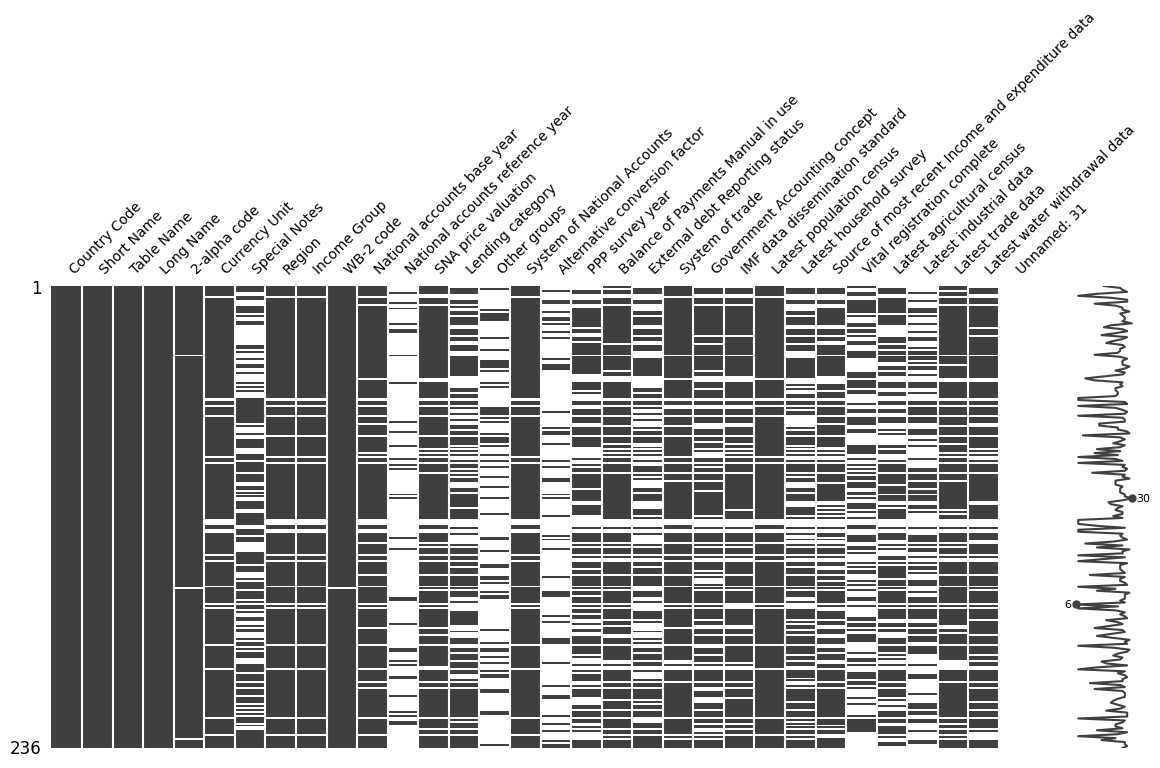

In [13]:
# Plot the completion using Missingno
_ = msno.matrix(df=country, figsize=(14,6), fontsize=10)

There is a lot of missing data, and the last column is empty.

## 2.2. CountrySeries dataset

In [14]:
# Let's have a look at its shape
print("This dataset contains {} rows and {} columns".format(
    countrySeries.shape[0], countrySeries.shape[1]))

This dataset contains 613 rows and 4 columns


In [15]:
# Overview of what information it contains
print(tabulate(countrySeries.head(5), headers='keys', tablefmt='github'))

|    | CountryCode   | SeriesCode        | DESCRIPTION                                              |   Unnamed: 3 |
|----|---------------|-------------------|----------------------------------------------------------|--------------|
|  0 | ABW           | SP.POP.TOTL       | Data sources : United Nations World Population Prospects |          nan |
|  1 | ABW           | SP.POP.GROW       | Data sources: United Nations World Population Prospects  |          nan |
|  2 | AFG           | SP.POP.GROW       | Data sources: United Nations World Population Prospects  |          nan |
|  3 | AFG           | NY.GDP.PCAP.PP.CD | Estimates are based on regression.                       |          nan |
|  4 | AFG           | SP.POP.TOTL       | Data sources : United Nations World Population Prospects |          nan |


This table seems to be a mapping between Country and Series.

In [16]:
# Gather some basic information
countrySeries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


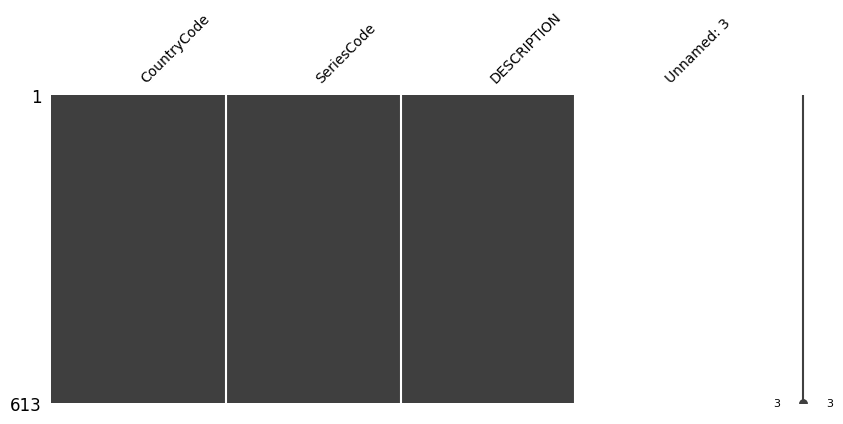

In [17]:
# Plot the completion using Missingno
_ = msno.matrix(df=countrySeries, figsize=(10,4), fontsize=10)

The last column will not be considered as it is empty.

## 2.3. Data dataset

In [18]:
# Let's have a look at its shape
print("This dataset contains {} rows and {} columns".format(
    data.shape[0], data.shape[1]))

This dataset contains 886930 rows and 70 columns


In [19]:
# Overview of what information it contains
print(tabulate(data.head(5), headers='keys', tablefmt='github'))

|    | Country Name   | Country Code   | Indicator Name                                                          | Indicator Code   |     1970 |     1971 |     1972 |     1973 |     1974 |     1975 |   1976 |     1977 |     1978 |     1979 |     1980 |     1981 |     1982 |     1983 |     1984 |     1985 |     1986 |     1987 |     1988 |     1989 |     1990 |     1991 |     1992 |     1993 |     1994 |     1995 |     1996 |     1997 |     1998 |     1999 |     2000 |     2001 |     2002 |     2003 |     2004 |     2005 |     2006 |     2007 |     2008 |    2009 |    2010 |     2011 |     2012 |     2013 |     2014 |   2015 |   2016 |   2017 |   2020 |   2025 |   2030 |   2035 |   2040 |   2045 |   2050 |   2055 |   2060 |   2065 |   2070 |   2075 |   2080 |   2085 |   2090 |   2095 |   2100 |   Unnamed: 69 |
|----|----------------|----------------|-------------------------------------------------------------------------|------------------|----------|----------|----------|----------|--

This table seems to be the main dataset, which contains the actual indicators, listed by countries (multiple rows by country).

Each row countains the evolution for 1 indicator for 1 country, over several years (listed in columns).

In [20]:
# Gather some basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

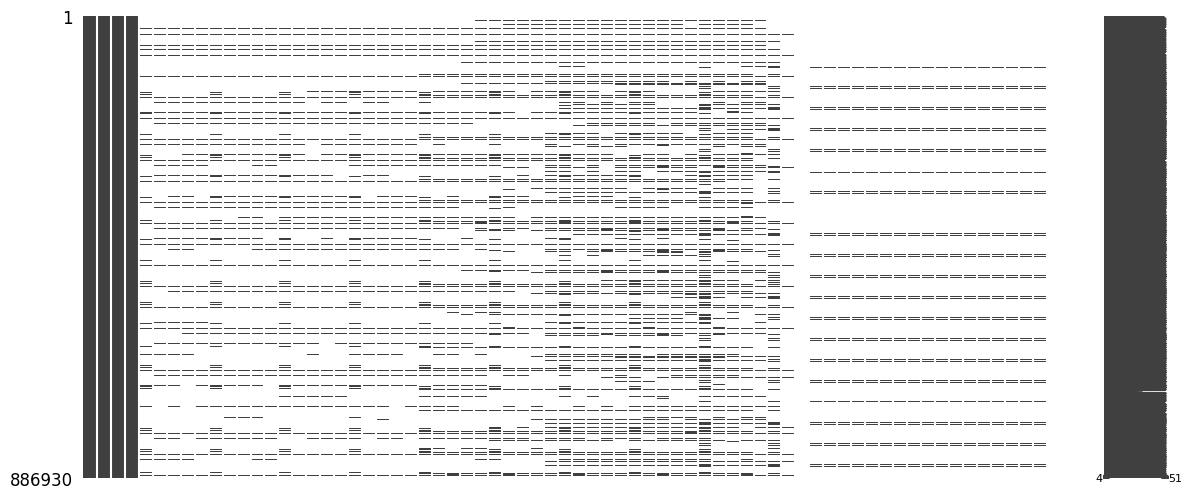

In [21]:
# Plot the completion using Missingno
_ = msno.matrix(df=data, figsize=(14,6), fontsize=10)

Last column is empty, so it will be discarded.

## 2.4. FootNote dataset

In [22]:
# Let's have a look at its shape
print("This dataset contains {} rows and {} columns".format(
    footNote.shape[0], footNote.shape[1]))

This dataset contains 643638 rows and 5 columns


In [23]:
# Overview of what information it contains
print(tabulate(footNote.head(5), headers='keys', tablefmt='github'))

|    | CountryCode   | SeriesCode     | Year   | DESCRIPTION         |   Unnamed: 4 |
|----|---------------|----------------|--------|---------------------|--------------|
|  0 | ABW           | SE.PRE.ENRL.FE | YR2001 | Country estimation. |          nan |
|  1 | ABW           | SE.TER.TCHR.FE | YR2005 | Country estimation. |          nan |
|  2 | ABW           | SE.PRE.TCHR.FE | YR2000 | Country estimation. |          nan |
|  3 | ABW           | SE.SEC.ENRL.GC | YR2004 | Country estimation. |          nan |
|  4 | ABW           | SE.PRE.TCHR    | YR2006 | Country estimation. |          nan |


This table seems to also be a mapping between Country and Series, but with an added column 'Year'. It would seem that each year an indicator is filled for a country there would be a record here.

1 row = 1 country, 1 indicator, 1 year.

In [24]:
# Gather some basic information
footNote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


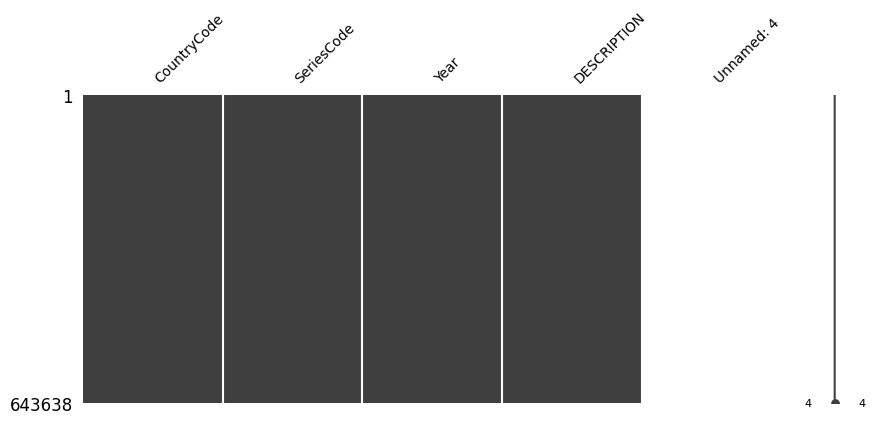

In [25]:
# Plot the completion using Missingno
_ = msno.matrix(df=footNote, figsize=(10,4), fontsize=10)

## 2.5. Series dataset

In [26]:
# Let's have a look at its shape
print("This dataset contains {} rows and {} columns".format(
    series.shape[0], series.shape[1]))

This dataset contains 3665 rows and 21 columns


In [27]:
# Overview of what information it contains
print(tabulate(series.head(5), headers='keys', tablefmt='github'))

|    | Series Code         | Topic      | Indicator Name                                                         | Short definition                                            | Long definition                                             |   Unit of measure |   Periodicity |   Base Period |   Other notes |   Aggregation method |   Limitations and exceptions |   Notes from original source |   General comments | Source                                                     |   Statistical concept and methodology |   Development relevance |   Related source links |   Other web links |   Related indicators |   License Type |   Unnamed: 20 |
|----|---------------------|------------|------------------------------------------------------------------------|-------------------------------------------------------------|-------------------------------------------------------------|-------------------|---------------|---------------|---------------|----------------------|------------------------------

This table gives the explanation of the Series codes.

'Short definition' and 'Long definition' seem redundant with 'Indicator Name'.

In [28]:
# Gather some basic information
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

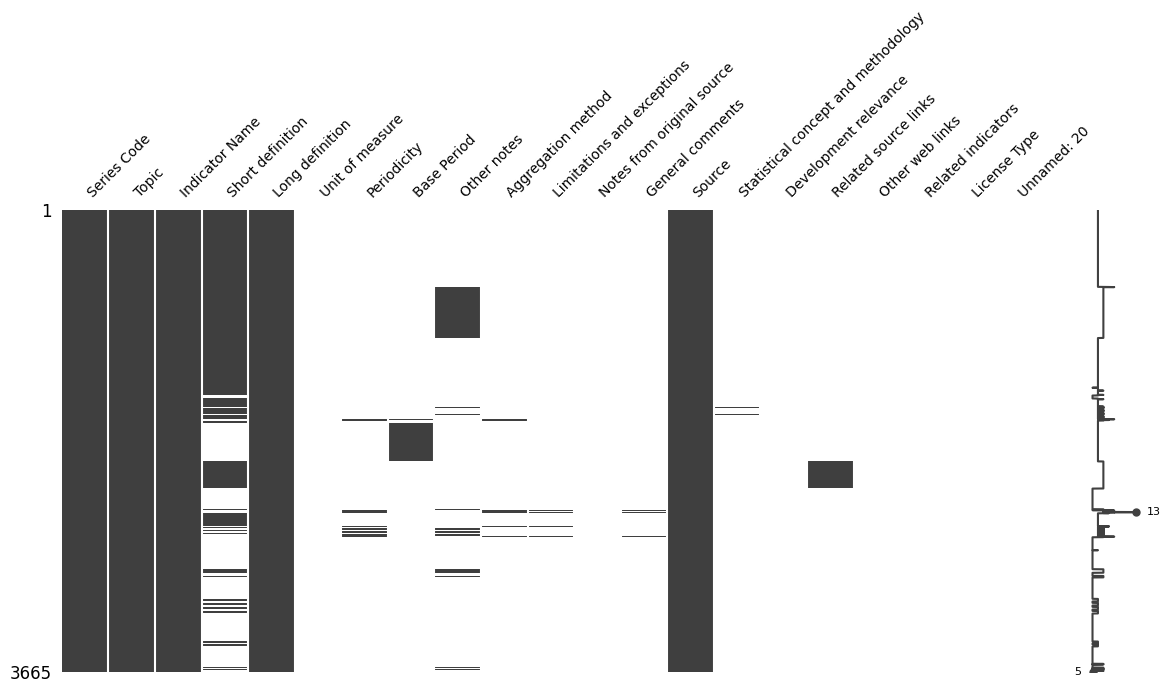

In [29]:
# Plot the completion using Missingno
_ = msno.matrix(df=series, figsize=(14,6), fontsize=10)

There is a lot of missing data, including the last column.

# 3. Data preparation (cleaning and completion)

## 3.1. Column selection

From what has been seen previously, the datasets countrySeries and footNote contain redundant from data, so they are discarded.

In [30]:
# Since I also want 'fresh' data, I define a recency filter to year 2000
recency_filter = 2000

### 3.1.1. country dataset

In [31]:
list(country.columns)

['Country Code',
 'Short Name',
 'Table Name',
 'Long Name',
 '2-alpha code',
 'Currency Unit',
 'Special Notes',
 'Region',
 'Income Group',
 'WB-2 code',
 'National accounts base year',
 'National accounts reference year',
 'SNA price valuation',
 'Lending category',
 'Other groups',
 'System of National Accounts',
 'Alternative conversion factor',
 'PPP survey year',
 'Balance of Payments Manual in use',
 'External debt Reporting status',
 'System of trade',
 'Government Accounting concept',
 'IMF data dissemination standard',
 'Latest population census',
 'Latest household survey',
 'Source of most recent Income and expenditure data',
 'Vital registration complete',
 'Latest agricultural census',
 'Latest industrial data',
 'Latest trade data',
 'Latest water withdrawal data',
 'Unnamed: 31']

In [32]:
# From country, only keep: 'Country Code', 'Table Name', 'Region', 
# 'Income Group', 'Latest population census'
keep_country = ['Country Code', 'Table Name', 'Region', 'Income Group', 
                'Latest population census']

country_short = country[keep_country]

Since I also want to work on relatively recent data, I will filter on the lastest population census.

In [33]:
# What are the unique values here?
country_short['Latest population census'].unique()

array(['2010', '1979', '1970', '2011',
       '2011. Population figures compiled from administrative registers.',
       nan, '2009', '2008', '2013', '2006', '2012', '2005', '2003',
       'Guernsey: 2009; Jersey: 2011.', '1998', '1984', '2007',
       '2006. Rolling census based on continuous sample survey.', '2002',
       '1996',
       '2011. The population censuses for 1986 and 1996 were based on a one-in-seven sample of the population, while that for 2006 was based on a one-in-ten sample of the population.',
       '1997', '2004', '1993', '1983', '1987', '2001', '1989'],
      dtype=object)

In [34]:
# First I create a dictionnary to map to the news values:
new_vals = {1970:['1970'], 
            1979:['1979'], 
            1983:['1983'], 
            1984:['1984'], 
            1987:['1987'], 
            1989:['1989'], 
            1993:['1993'], 
            1996:['1996'], 
            1997:['1997'], 
            1998:['1998'], 
            2001:['2001'], 
            2002:['2002'], 
            2003:['2003'], 
            2004:['2004'], 
            2005:['2005'], 
            2006:['2006', 
                  '2006. Rolling census based on continuous sample survey.'], 
            2007:['2007'], 
            2008:['2008'], 
            2009:['2009'], 
            2010:['2010'], 
            2011:['2011', 
                  '2011. Population figures compiled from administrative registers.', 
                  'Guernsey: 2009; Jersey: 2011.', 
                  '2011. The population censuses for 1986 and 1996 were based on a one-in-seven sample of the population, while that for 2006 was based on a one-in-ten sample of the population.'], 
            2012:['2012'], 
            2013:['2013']
            }

# I then swap the keys to create a dictonnary that I can use:
map_dict = {k: oldk for oldk, oldv in new_vals.items() for k in oldv}

In [35]:
# I now create my new column:
country_short['LatestPopCensus_num'] = country_short['Latest population census'].\
  map(map_dict).fillna(0).astype('int')

<ipython-input-35-5db718c15c9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_short['LatestPopCensus_num'] = country_short['Latest population census'].\


In [36]:
# I can now drop the column 'Latest population census'
country_short = country_short.drop(columns=['Latest population census'], 
                                   inplace=False).copy()
print(tabulate(country_short.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   LatestPopCensus_num |
|----|----------------|--------------|---------------------------|----------------------|-----------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |                  2010 |
|  1 | AFG            | Afghanistan  | South Asia                | Low income           |                  1979 |
|  2 | AGO            | Angola       | Sub-Saharan Africa        | Upper middle income  |                  1970 |
|  3 | ALB            | Albania      | Europe & Central Asia     | Upper middle income  |                  2011 |
|  4 | AND            | Andorra      | Europe & Central Asia     | High income: nonOECD |                  2011 |


In [37]:
# I filter my data by selecting only recent values (after 2000)
country_filtered = country_short.loc[
    country_short['LatestPopCensus_num']>=recency_filter]

In [38]:
# I can now drop the column 'LatestPopCensus_num'
country_filtered = country_filtered.drop(columns=['LatestPopCensus_num'], 
                                         inplace=False).copy()

In [39]:
# Let's perform some basic check
country_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 240
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Code  200 non-null    object
 1   Table Name    200 non-null    object
 2   Region        199 non-null    object
 3   Income Group  199 non-null    object
dtypes: object(4)
memory usage: 7.8+ KB


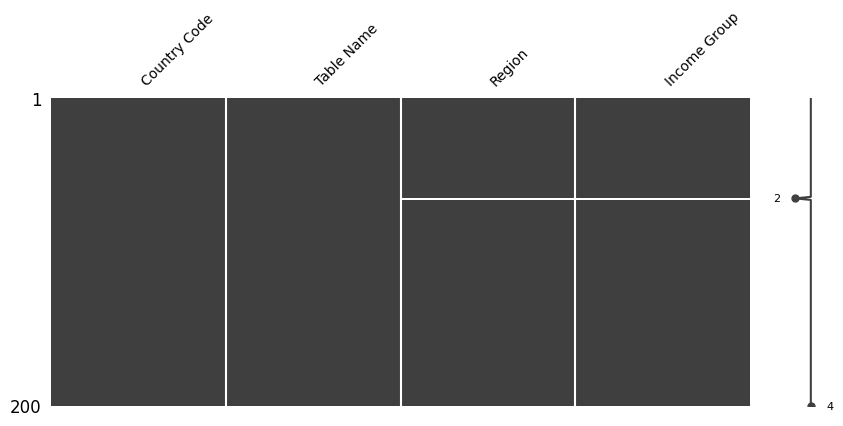

In [40]:
_ = msno.matrix(df=country_filtered, figsize=(10,4), fontsize=10)

### 3.1.2. data dataset

In [41]:
list(data.columns)

['Country Name',
 'Country Code',
 'Indicator Name',
 'Indicator Code',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2020',
 '2025',
 '2030',
 '2035',
 '2040',
 '2045',
 '2050',
 '2055',
 '2060',
 '2065',
 '2070',
 '2075',
 '2080',
 '2085',
 '2090',
 '2095',
 '2100',
 'Unnamed: 69']

In [42]:
# From data_ds, only keep: 'Country Code', 'Indicator Code', 'Indicator Name' 
# and years after 2000 (recency filter). 2017 is empty so don't keep the column.
# The years after 2017 feel like speculation, so do not consider them.
keep_data = ['Country Code', 'Indicator Code', 'Indicator Name', '2000','2001', 
             '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
             '2010', '2011', '2012', '2013', '2014', '2015', '2016']

data_short = data[keep_data]

In [43]:
# Let's perform some basic check
data_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Code    886930 non-null  object 
 1   Indicator Code  886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   2000            176676 non-null  float64
 4   2001            123509 non-null  float64
 5   2002            124205 non-null  float64
 6   2003            130363 non-null  float64
 7   2004            128814 non-null  float64
 8   2005            184108 non-null  float64
 9   2006            140312 non-null  float64
 10  2007            137272 non-null  float64
 11  2008            134387 non-null  float64
 12  2009            142108 non-null  float64
 13  2010            242442 non-null  float64
 14  2011            146012 non-null  float64
 15  2012            147264 non-null  float64
 16  2013            137509 non-null  float64
 17  2014      

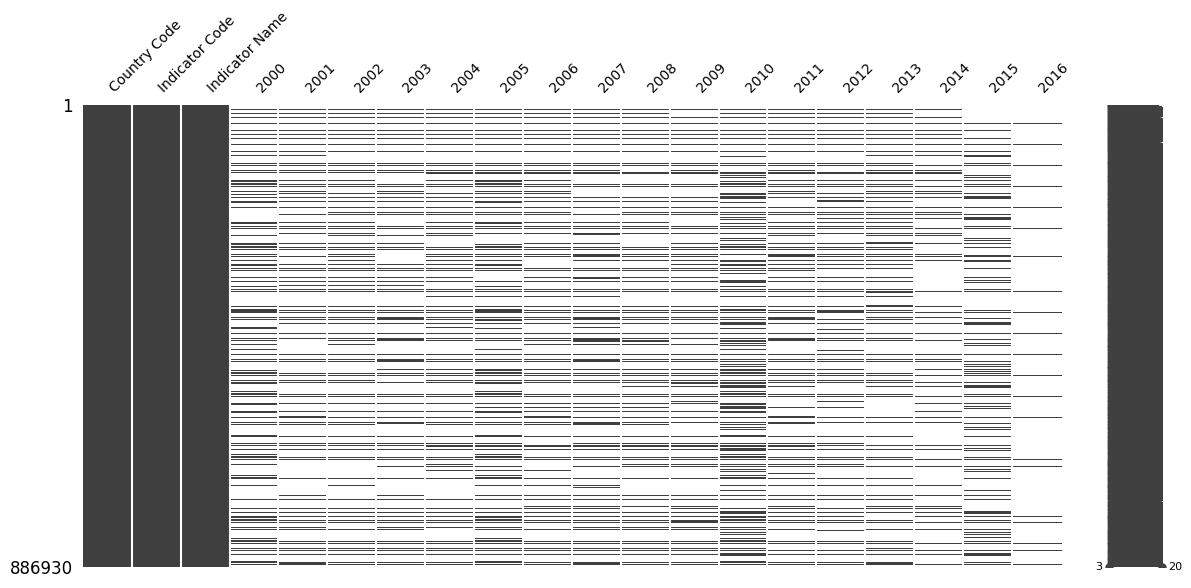

In [44]:
_ = msno.matrix(df=data_short, figsize=(14,6), fontsize=10)

### 3.1.3. series dataset

In [45]:
list(series.columns)

['Series Code',
 'Topic',
 'Indicator Name',
 'Short definition',
 'Long definition',
 'Unit of measure',
 'Periodicity',
 'Base Period',
 'Other notes',
 'Aggregation method',
 'Limitations and exceptions',
 'Notes from original source',
 'General comments',
 'Source',
 'Statistical concept and methodology',
 'Development relevance',
 'Related source links',
 'Other web links',
 'Related indicators',
 'License Type',
 'Unnamed: 20']

In [46]:
# From series_ds, only keep: 'Series Code', 'Topic', 'Indicator Name'
keep_series = ['Series Code', 'Topic', 'Indicator Name']

series_short = series[keep_series]

In [47]:
# Let's perform some basic check
series_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Series Code     3665 non-null   object
 1   Topic           3665 non-null   object
 2   Indicator Name  3665 non-null   object
dtypes: object(3)
memory usage: 86.0+ KB


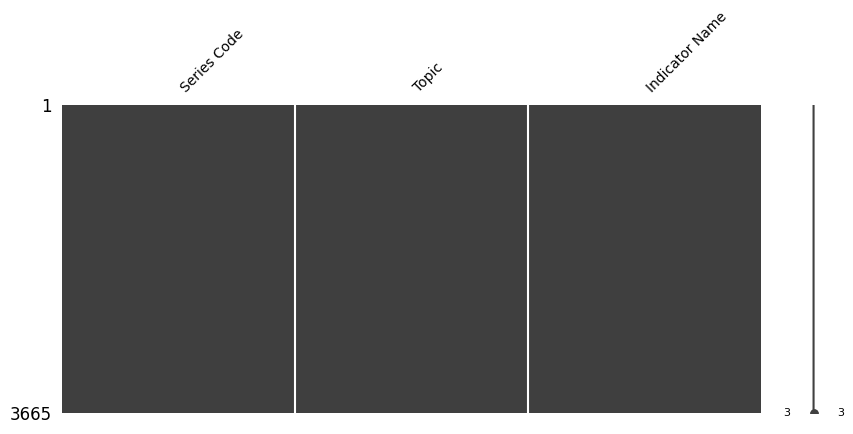

In [48]:
_ = msno.matrix(df=series_short, figsize=(10,4), fontsize=10)

## 3.2. Drop duplicates (if any)

In [49]:
# Let's delete the duplicates that may have appeared with the columns deletion:
print("country_filtered contains {} rows and {} columns".format(
    country_filtered.shape[0], country_filtered.shape[1]))
country_filtered = country_filtered.drop_duplicates(inplace=False, 
                                                    ignore_index=True).copy()
print("After de-duplication, country_filtered contains {} rows and {} columns".
      format(country_filtered.shape[0], country_filtered.shape[1]))

print("data_short contains {} rows and {} columns".format(
    data_short.shape[0], data_short.shape[1]))
data_short = data_short.drop_duplicates(inplace=False, ignore_index=True).copy()
print("After de-duplication, data_short contains {} rows and {} columns".
      format(data_short.shape[0], data_short.shape[1]))

print("series_short contains {} rows and {} columns".format(
    series_short.shape[0], series_short.shape[1]))
series_short = series_short.drop_duplicates(inplace=False, 
                                            ignore_index=True).copy()
print("After de-duplication, series_short contains {} rows and {} columns".
      format(series_short.shape[0], series_short.shape[1]))

country_filtered contains 200 rows and 4 columns
After de-duplication, country_filtered contains 200 rows and 4 columns
data_short contains 886930 rows and 20 columns
After de-duplication, data_short contains 886930 rows and 20 columns
series_short contains 3665 rows and 3 columns
After de-duplication, series_short contains 3665 rows and 3 columns


Looks like there are no duplicates!

## 3.3. Filter according to the problem:
- High internet access (online courses)
- Target level high-school to university (15-25 yrs)

### 3.3.1. Internet access

In [50]:
# Let's recall how what the dataframe looks like
print(tabulate(series_short.head(5), headers='keys', tablefmt='github'))

|    | Series Code         | Topic      | Indicator Name                                                         |
|----|---------------------|------------|------------------------------------------------------------------------|
|  0 | BAR.NOED.1519.FE.ZS | Attainment | Barro-Lee: Percentage of female population age 15-19 with no education |
|  1 | BAR.NOED.1519.ZS    | Attainment | Barro-Lee: Percentage of population age 15-19 with no education        |
|  2 | BAR.NOED.15UP.FE.ZS | Attainment | Barro-Lee: Percentage of female population age 15+ with no education   |
|  3 | BAR.NOED.15UP.ZS    | Attainment | Barro-Lee: Percentage of population age 15+ with no education          |
|  4 | BAR.NOED.2024.FE.ZS | Attainment | Barro-Lee: Percentage of female population age 20-24 with no education |


In [51]:
# First, focus on the internet access
# Let's define the keyword we're be looking at:
kw = 'Internet'

print('Keyword searched: {}\n'.format(kw))
# Search for the occurences
searched_kw = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_kw.shape}")

Keyword searched: Internet

Shape of the result: (1, 3)


In [52]:
# Let's visualize the result (as it is small)
print(tabulate(searched_kw, headers='keys', tablefmt='github'))

|     | Series Code    | Topic                          | Indicator Name                  |
|-----|----------------|--------------------------------|---------------------------------|
| 611 | IT.NET.USER.P2 | Infrastructure: Communications | Internet users (per 100 people) |


In [53]:
# Let's keep this indicator somewhere
found_indic = []
found_indic.append('IT.NET.USER.P2')

Seems this is a good indicator (IT.NET.USER.P2), let's keep it around.

### 3.3.2. Education

In [54]:
# Now, let's try to find about their education
kw = 'Education'

print('Keyword searched: {}\n'.format(kw))
# Search for the occurences
searched_kw = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_kw.shape}")

Keyword searched: Education

Shape of the result: (1092, 3)


In [55]:
# There are a lot of records, so let's try to narrow it down using the topic.
# What are the different topics here?
list(searched_kw['Topic'].unique())

['Attainment',
 'Education Equality',
 'Learning Outcomes',
 'Education Management Information Systems (SABER)',
 'School Health and School Feeding (SABER)',
 'School Finance (SABER)',
 'Teachers (SABER)',
 'Tertiary Education (SABER)',
 'Background',
 'Early Childhood Education',
 'Teachers',
 'Primary',
 'Secondary',
 'Tertiary',
 'Expenditures',
 'Social Protection & Labor: Labor force structure',
 'Laber',
 'Population',
 'Post-Secondary/Non-Tertiary',
 'Pre-Primary']

#### 3.3.2.1. By topic: Attainment

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Attainment'
# Let's define the topic we're looking at:
#topic = 'Attainment'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

It's only about projections and percentages, that does not interest me here.

#### 3.3.2.2. By topic: Education Equality

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Education Equality'
#topic = 'Education Equality'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

I will not use these indicators here.

#### 3.3.2.3. By topic: Learning Outcomes

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Learning Outcomes'
#topic = 'Learning Outcomes'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

It's about performance, so I will not use these.

#### 3.3.2.4. By topic: related to SABER

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topics related to 'SABER'
#topic = 'SABER'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

These are about policies goals. I will not consider them.

#### 3.3.2.5. By topic: Background

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Background'
#topic = 'Background'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

Not much here.

#### 3.3.2.6. By topic: Early Childhood Education

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Early Childhood Education'
#topic = 'Early Childhood Education'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

The target is too young here (as expected should I say).

#### 3.3.2.7. By topic: Teachers

In [57]:
# Let's see what we have with the topic 'Teachers'
topic = 'Teachers'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Education
Topic being searched: Teachers

Shape of the result: (110, 3)


In [58]:
# From these indicators, some could prove useful:
teachers_indic = ['Teachers in secondary education, both sexes (number)', 
                  'Teachers in tertiary education programmes, both sexes (number)', 
                  'Teachers in secondary general education, both sexes (number)', 
                  'Teachers in upper secondary education, both sexes (number)', 
                  'Teachers in post-secondary non-tertiary education, both sexes (number)', 
                  'Teachers in tertiary education ISCED 5 programmes, both sexes (number)']

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(teachers_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code   | Topic    | Indicator Name                                                         |
|------|---------------|----------|------------------------------------------------------------------------|
| 2326 | SE.SEC.TCHR   | Teachers | Teachers in secondary education, both sexes (number)                   |
| 2369 | SE.TER.TCHR   | Teachers | Teachers in tertiary education programmes, both sexes (number)         |
| 3523 | UIS.T.23.GPV  | Teachers | Teachers in secondary general education, both sexes (number)           |
| 3527 | UIS.T.3       | Teachers | Teachers in upper secondary education, both sexes (number)             |
| 3529 | UIS.T.4       | Teachers | Teachers in post-secondary non-tertiary education, both sexes (number) |
| 3531 | UIS.T.5.B     | Teachers | Teachers in tertiary education ISCED 5 programmes, both sexes (number) |


In [59]:
# Let's add them to the list:
# For each indicator, we need to retrieve its associated 'Series Code'
# We then extract its 'values', and the [0] enables the access to the raw value
for item in teachers_indic:
  found_indic.append(series_short[series_short['Indicator Name'] == item]
                     ['Series Code'].values[0])

#### 3.3.2.8. By topic: Primary

In [ ]:
# NO RUN CELL (no useful info)

# Let's continue and see what we have with the topic 'Primary'
#topic = 'Primary'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

As expected, these indicators do not interest us.

#### 3.3.2.9. By topic: Secondary

In [60]:
# Let's see what we have with the topic 'Secondary'
topic = 'Secondary'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Education
Topic being searched: Secondary

Shape of the result: (169, 3)


In [61]:
# From these indicators, some of them could prove useful:
secondary_indic = ['Enrolment in secondary education, both sexes (number)', 
                   'Enrolment in secondary education, private institutions, both sexes (number)', 
                   'Enrolment in secondary education, public institutions, both sexes (number)',
                   'Enrolment in upper secondary education, both sexes (number)', 
                   'Enrolment in upper secondary education, private institutions, both sexes (number)', 
                   'Enrolment in upper secondary education, public institutions, both sexes (number)']

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(secondary_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code   | Topic     | Indicator Name                                                                    |
|------|---------------|-----------|-----------------------------------------------------------------------------------|
| 2294 | SE.SEC.ENRL   | Secondary | Enrolment in secondary education, both sexes (number)                             |
| 2821 | UIS.E.23.PR   | Secondary | Enrolment in secondary education, private institutions, both sexes (number)       |
| 2823 | UIS.E.23.Pu   | Secondary | Enrolment in secondary education, public institutions, both sexes (number)        |
| 2825 | UIS.E.3       | Secondary | Enrolment in upper secondary education, both sexes (number)                       |
| 2829 | UIS.E.3.PR    | Secondary | Enrolment in upper secondary education, private institutions, both sexes (number) |
| 2831 | UIS.E.3.PU    | Secondary | Enrolment in upper secondary education, public institutions, both sexes (number)  |


In [62]:
# Let's add them to the list:
for item in secondary_indic:
  found_indic.append(series_short[series_short['Indicator Name'] == item]
                     ['Series Code'].values[0])

#### 3.3.2.10. By topic: Tertiary

In [63]:
# Let's continue and see what we have with the topic 'Tertiary'
topic = 'Tertiary'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Education
Topic being searched: Tertiary

Shape of the result: (152, 3)


Here, I am using a reference to [Wikipedia](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Education) to understand that:
- ISCED 5 corresponds to short-cycle tertiary education and prepare for labour market entry,
- ISCED 6 corresponds to a Bachelor's,
- ISCED 7 corresponds to a Master's,
- ISCED 8 corresponds to a Doctorate.

In [64]:
# From these indicators, some of them could prove useful:
tertiary_indic = ['Enrolment in tertiary education, all programmes, both sexes (number)', 
                  'Graduates from tertiary education, both sexes (number)', 
                  'Enrolment in post-secondary non-tertiary education, both sexes (number)', 
                  'Enrolment in post-secondary non-tertiary education, private institutions, both sexes (number)', 
                  'Enrolment in post-secondary non-tertiary education, public institutions, both sexes (number)', 
                  'Enrolment in tertiary education, ISCED 5 programmes, both sexes (number)', 
                  'Enrolment in tertiary education, ISCED 6 programmes, both sexes (number)', 
                  'Enrolment in tertiary education, ISCED 7 programmes, both sexes (number)', 
                  'Graduates from ISCED 5 programmes in tertiary education, both sexes (number)', 
                  'Graduates from ISCED 6 programmes in tertiary education, both sexes (number)', 
                  'Graduates from ISCED 7 programmes in tertiary education, both sexes (number)']

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(tertiary_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code   | Topic                       | Indicator Name                                                                                |
|------|---------------|-----------------------------|-----------------------------------------------------------------------------------------------|
| 2332 | SE.TER.ENRL   | Tertiary                    | Enrolment in tertiary education, all programmes, both sexes (number)                          |
| 2338 | SE.TER.GRAD   | Tertiary                    | Graduates from tertiary education, both sexes (number)                                        |
| 2835 | UIS.E.4       | Tertiary                    | Enrolment in post-secondary non-tertiary education, both sexes (number)                       |
| 2837 | UIS.E.4.PR    | Post-Secondary/Non-Tertiary | Enrolment in post-secondary non-tertiary education, private institutions, both sexes (number) |
| 2839 | UIS.E.4.Pu    | Tertiary                    | Enrolment in post-secondary non-tertiar

In [65]:
# Let's add them to the list:
for item in tertiary_indic:
  found_indic.append(series_short[series_short['Indicator Name'] == item]
                     ['Series Code'].values[0])

#### 3.3.2.11. By topic: Expenditures

In [66]:
# Let's continue and see what we have with the topic 'Expenditures'
topic = 'Expenditures'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Education
Topic being searched: Expenditures

Shape of the result: (20, 3)


In [67]:
# From these indicators, we can use the following:
expend_indic = ['Government expenditure on education as % of GDP (%)', 
                'Government expenditure in educational institutions as % of GDP (%)']

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(expend_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code                  | Topic        | Indicator Name                                                     |
|------|------------------------------|--------------|--------------------------------------------------------------------|
| 2381 | SE.XPD.TOTL.GD.ZS            | Expenditures | Government expenditure on education as % of GDP (%)                |
| 3590 | UIS.XGDP.FSgov.FDinstadm.FFd | Expenditures | Government expenditure in educational institutions as % of GDP (%) |


In [68]:
# Let's add them to the list:
for item in expend_indic:
  found_indic.append(series_short[series_short['Indicator Name'] == item]
                     ['Series Code'].values[0])

#### 3.3.2.12. By topic: Social Protection & Labor: Labor force structure

In [ ]:
# NO RUN CELL (no useful info)

# Let's continue and see what we have with the topic 
# 'Social Protection & Labor: Labor force structure'
#topic = 'Social Protection & Labor: Labor force structure'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

As expected, not much can be used here.

#### 3.3.2.13. By topic: Laber

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Laber'
#topic = 'Laber'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

Could be useful, but 'youth' is not clearly defined.

#### 3.3.2.14. By topic: Population

In [69]:
# Let's continue and see what we have with the topic 'Population'
topic = 'Population'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Education
Topic being searched: Population

Shape of the result: (30, 3)


In [70]:
# From these indicators, we can use the following:
pop_indic = ['Population of the official age for secondary education, both sexes (number)', 
             'Population of the official age for upper secondary education, both sexes (number)', 
             'Population of the official age for tertiary education, both sexes (number)', 
             'Population of the official age for post-secondary non-tertiary education, both sexes (number)']

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(pop_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code    | Topic      | Indicator Name                                                                                |
|------|----------------|------------|-----------------------------------------------------------------------------------------------|
| 2608 | SP.SEC.TOTL.IN | Population | Population of the official age for secondary education, both sexes (number)                   |
| 2611 | SP.SEC.UTOT.IN | Population | Population of the official age for upper secondary education, both sexes (number)             |
| 2614 | SP.TER.TOTL.IN | Population | Population of the official age for tertiary education, both sexes (number)                    |
| 3473 | UIS.SAP.4      | Population | Population of the official age for post-secondary non-tertiary education, both sexes (number) |


In [71]:
# Let's add them to the list:
for item in pop_indic:
  found_indic.append(series_short[series_short['Indicator Name'] == item]
                     ['Series Code'].values[0])

#### 3.3.2.15. By topic: Post-Secondary/Non-Tertiary

In [ ]:
# NO RUN CELL (no useful info)

# Let's continue and see what we have with the topic 
# 'Post-Secondary/Non-Tertiary'
#topic = 'Post-Secondary/Non-Tertiary'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

Mainly percentages, so I will not use them.

#### 3.3.2.16. By topic: Pre-Primary

In [ ]:
# NO RUN CELL (no useful info)

# Let's continue and see what we have with the topic 'Pre-Primary'
#topic = 'Pre-Primary'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

We have a bunch of interesting indicators. Let's dive a bit deeper, and try to gather information about the population to set a basis for comparison.

### 3.3.3. Population

In [72]:
# Let's try to find about the population
kw = 'Population'

print('Keyword searched: {}\n'.format(kw))
# Search for the occurences
searched_kw = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_kw.shape}")

Keyword searched: Population

Shape of the result: (847, 3)


In [73]:
# Again, there are a lot of records, so let's try to narrow it down.
# What are the different topics here?
list(series_short[series_short['Indicator Name'].
                  str.contains(kw, regex=False, case=False)]['Topic'].unique())

['Attainment',
 'Literacy',
 'Health: Risk factors',
 'Social Protection & Labor: Labor force structure',
 'Laber',
 'Health: Population: Structure',
 'Population',
 'Health: Population: Dynamics']

#### 3.3.3.1. By topic: Attainment

In [ ]:
# NO RUN CELL (no useful info)

# Let's see what we have with the topic 'Attainment'
# Let's define the topic we're looking at:
#topic = 'Attainment'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

We could use some indicators with 'Barro-Lee', but since I don't exactly know what they mean and how they are measured, I will not use them.

#### 3.3.3.2. By topic: Literacy

In [74]:
# Let's continue with the topic 'Literacy'
topic = 'Literacy'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Population
Topic being searched: Literacy

Shape of the result: (32, 3)


In [75]:
# From these indicators, we can use the following one:
lit_indic = ['Youth illiterate population, 15-24 years, both sexes (number)']

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(lit_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code    | Topic    | Indicator Name                                                |
|------|----------------|----------|---------------------------------------------------------------|
| 3052 | UIS.LP.Ag15t24 | Literacy | Youth illiterate population, 15-24 years, both sexes (number) |


In [76]:
# Let's add it to the list:
found_indic.append(lit_indic[0])

#### 3.3.3.3. By topic: Health: Risk factors

In [ ]:
# NO RUN CELL (no useful info)

# Let's continue with the topic 'Health: Risk factors'
#topic = 'Health: Risk factors'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

Not very useful, let's move to the next one.

#### 3.3.3.4. By topic: Social Protection & Labor: Labor force structure

In [ ]:
# NO RUN CELL (no useful info)

# 'Social Protection & Labor: Labor force structure'
#topic = 'Social Protection & Labor: Labor force structure'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

Seems quite subjective (what do these levels of education mean?), so I am not using them.

#### 3.3.3.5. By topic: Laber

In [ ]:
# NO RUN CELL (no useful info)

# Let's continue with the topic 'Laber'
#topic = 'Laber'

#print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

Not much to see here.

#### 3.3.3.6. By topic: Population

In [77]:
# Let's continue with the topic 'Population' 
# (including 'Health: Population: Structure' and 'Health: Population: Dynamics')
topic = 'Population'

print('Keyword searched: {}\nTopic being searched: {}\n'.format(kw, topic))
# Run cells below to access the list
#print(tabulate(series_short[series_short['Indicator Name'].
#                            str.contains(kw, regex=False, case=False) 
#                            & series_short['Topic'].
#                            str.contains(topic, regex=False, case=False)], 
#               headers='keys', tablefmt='github'))

# I just print the shape here
# Search for the occurences
searched_topic = series_short[
    series_short['Indicator Name'].str.contains(kw, regex=False, case=False) 
    & series_short['Topic'].str.contains(topic, regex=False, case=False)]
# Print the shape of the result
print(f"Shape of the result: {searched_topic.shape}")

Keyword searched: Population
Topic being searched: Population

Shape of the result: (227, 3)


In [78]:
# From these indicators, we can use the following one:
pop2_indic = ['Population, ages 15-24, total', 
             'Population, total', 
             'Population of the official age for secondary education, both sexes (number)', 
             'Population of the official age for upper secondary education, both sexes (number)', 
             'Population of the official age for tertiary education, both sexes (number)', 
             'Population of the official age for post-secondary non-tertiary education, both sexes (number)']
# The last 4 indicators have already been seen with the keyword 'Education'

print(tabulate(series_short[series_short['Indicator Name'].
                            isin(pop2_indic)], 
               headers='keys', tablefmt='github'))

|      | Series Code       | Topic                         | Indicator Name                                                                                |
|------|-------------------|-------------------------------|-----------------------------------------------------------------------------------------------|
| 2506 | SP.POP.1524.TO.UN | Population                    | Population, ages 15-24, total                                                                 |
| 2590 | SP.POP.TOTL       | Health: Population: Structure | Population, total                                                                             |
| 2608 | SP.SEC.TOTL.IN    | Population                    | Population of the official age for secondary education, both sexes (number)                   |
| 2611 | SP.SEC.UTOT.IN    | Population                    | Population of the official age for upper secondary education, both sexes (number)             |
| 2614 | SP.TER.TOTL.IN    | Population                   

In [79]:
# Let's add them to the list:
for item in pop2_indic:
  found_indic.append(series_short[series_short['Indicator Name'] == item]
                     ['Series Code'].values[0])

That's enough indicators for now!

Let's recap what we could investigate here.

### 3.3.4. Review of the indicators & merging

In [80]:
# Here's the list of all the indicators we consider:
list(found_indic)

['IT.NET.USER.P2',
 'SE.SEC.TCHR',
 'SE.TER.TCHR',
 'UIS.T.23.GPV',
 'UIS.T.3',
 'UIS.T.4',
 'UIS.T.5.B',
 'SE.SEC.ENRL',
 'UIS.E.23.PR',
 'UIS.E.23.Pu',
 'UIS.E.3',
 'UIS.E.3.PR',
 'UIS.E.3.PU',
 'SE.TER.ENRL',
 'SE.TER.GRAD',
 'UIS.E.4',
 'UIS.E.4.PR',
 'UIS.E.4.Pu',
 'UIS.E.5.B',
 'UIS.E.6',
 'UIS.E.7',
 'UIS.G.5.B.T',
 'UIS.G.6.T',
 'UIS.G.7.T',
 'SE.XPD.TOTL.GD.ZS',
 'UIS.XGDP.FSgov.FDinstadm.FFd',
 'SP.SEC.TOTL.IN',
 'SP.SEC.UTOT.IN',
 'SP.TER.TOTL.IN',
 'UIS.SAP.4',
 'Youth illiterate population, 15-24 years, both sexes (number)',
 'SP.POP.1524.TO.UN',
 'SP.POP.TOTL',
 'SP.SEC.TOTL.IN',
 'SP.SEC.UTOT.IN',
 'SP.TER.TOTL.IN',
 'UIS.SAP.4']

In [81]:
# Let's remove the duplicates:
indic_dd = [i for n, i in enumerate(found_indic) if i not in found_indic[:n]]

In [82]:
# Now, to match what I did during my Master, I'll use the same list I used
# For a deeper analysis, this block can be commented/deleted
indic_dd = ['IT.NET.USER.P2', 'SP.POP.1524.TO.UN', 'SP.POP.TOTL', 'UIS.E.3', 
            'SE.TER.ENRL']

In [83]:
# With the indicators of interest, let's filter the data_short dataframe, 
# and discard the series_short dataframe:
data_filtered = data_short[data_short['Indicator Code'].isin(indic_dd)].copy()

In [84]:
# Let's review its shape:
print("data_filtered contains {} rows and {} columns".
      format(data_filtered.shape[0], data_filtered.shape[1]))

data_filtered contains 1210 rows and 20 columns


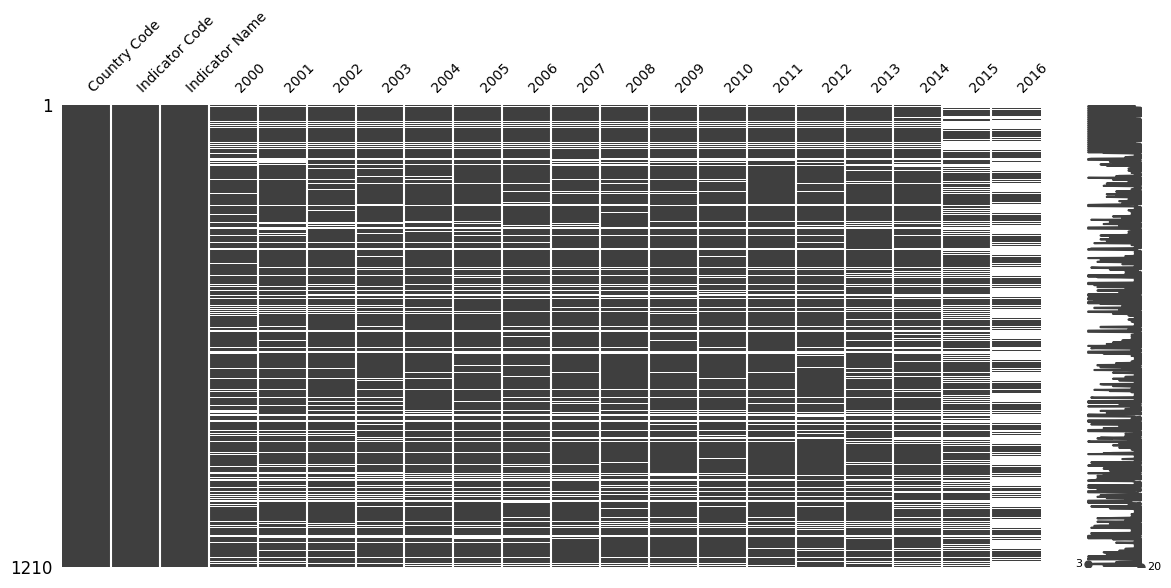

In [85]:
# Review its completion using Missingno
_ = msno.matrix(df=data_filtered, figsize=(14,6), fontsize=10)

In [86]:
print(tabulate(data_filtered.head(5), headers='keys', tablefmt='github'))

|      | Country Code   | Indicator Code    | Indicator Name                                                       |          2000 |          2001 |          2002 |          2003 |          2004 |          2005 |          2006 |          2007 |          2008 |          2009 |          2010 |          2011 |          2012 |          2013 |          2014 |   2015 |   2016 |
|------|----------------|-------------------|----------------------------------------------------------------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|--------|--------|
| 1204 | ARB            | SE.TER.ENRL       | Enrolment in tertiary education, all programmes, both sexes (number) |   5.08985e+06 |   5.40064e+06 |   5.7987e+06  |   5.95551e+06 |   6.46572e+06 |   6.89916e+06 |   7.21465e+06 |   7.58866e+06 |   8.0

In [87]:
print(tabulate(country_filtered.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name           | Region                     | Income Group         |
|----|----------------|----------------------|----------------------------|----------------------|
|  0 | ABW            | Aruba                | Latin America & Caribbean  | High income: nonOECD |
|  1 | ALB            | Albania              | Europe & Central Asia      | Upper middle income  |
|  2 | AND            | Andorra              | Europe & Central Asia      | High income: nonOECD |
|  3 | ARE            | United Arab Emirates | Middle East & North Africa | High income: nonOECD |
|  4 | ARG            | Argentina            | Latin America & Caribbean  | Upper middle income  |


In [93]:
# Finally, let's create the dataframe to study
init_data = data_filtered.merge(country_filtered, 
                                how='left', 
                                left_on='Country Code', 
                                right_on='Country Code')

## 3.4. Data quality check

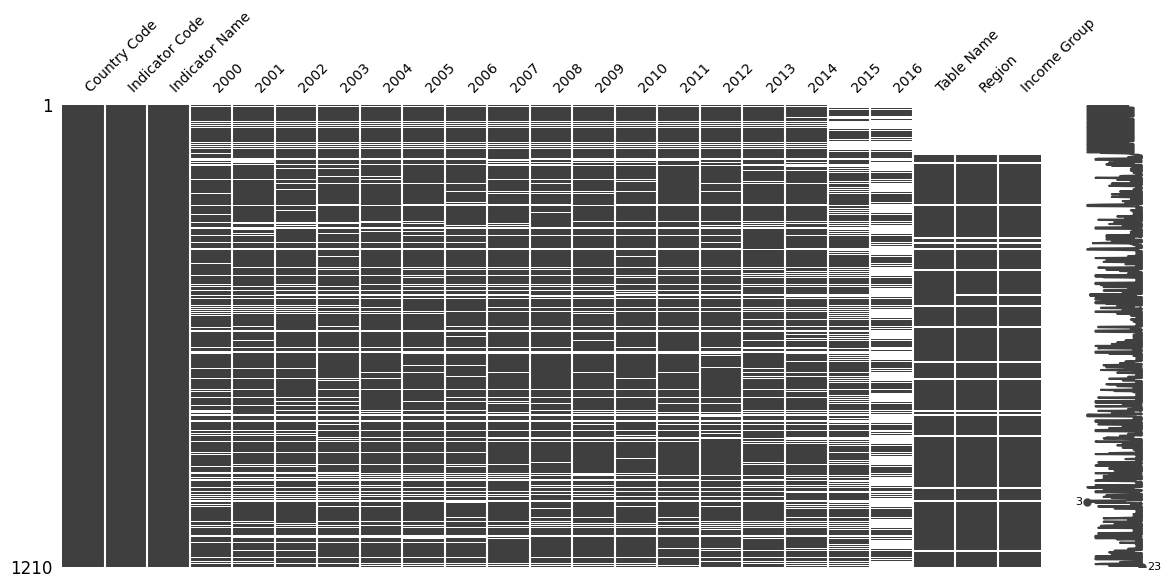

In [94]:
# Let's start with the missing values using Missingno
_ = msno.matrix(df=init_data, figsize=(14,6), fontsize=10)

In [95]:
# Now, let's unpivot on the years
init_data = pd.melt(init_data, 
                    id_vars=['Country Code', 'Indicator Code', 'Indicator Name', 
                             'Table Name', 'Region', 'Income Group'],
                    var_name='Year', value_name='Indicator Value').copy()
print(tabulate(init_data.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code    | Indicator Name                                                       |   Table Name |   Region |   Income Group |   Year |   Indicator Value |
|----|----------------|-------------------|----------------------------------------------------------------------|--------------|----------|----------------|--------|-------------------|
|  0 | ARB            | SE.TER.ENRL       | Enrolment in tertiary education, all programmes, both sexes (number) |          nan |      nan |            nan |   2000 |       5.08985e+06 |
|  1 | ARB            | UIS.E.3           | Enrolment in upper secondary education, both sexes (number)          |          nan |      nan |            nan |   2000 |       8.55494e+06 |
|  2 | ARB            | IT.NET.USER.P2    | Internet users (per 100 people)                                      |          nan |      nan |            nan |   2000 |       1.13954     |
|  3 | ARB            | SP.POP.1524.TO.UN | Population, ages 15-2

In [96]:
# Result should be (20570, 8) or close to
init_data.shape

(20570, 8)

In [97]:
# Let's now sort the dataset
data_sorted = init_data.sort_values(
    by=['Country Code', 'Indicator Code', 'Year'], ignore_index=True)
print(tabulate(data_sorted.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code   | Indicator Name                  | Table Name   | Region                    | Income Group         |   Year |   Indicator Value |
|----|----------------|------------------|---------------------------------|--------------|---------------------------|----------------------|--------|-------------------|
|  0 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |           15.4428 |
|  1 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |           17.1    |
|  2 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |           18.8    |
|  3 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD

### 3.4.1. (Indicator) Completion rate

For each Country Code, there are 5 (indicators) * 17 (years) = 85 lines.

Let's calculate a completion rate for each country.

In [98]:
# Define parameters to use
num_indic = 5
num_years = 17

# Start by initializing an empty list
completionRate = []

# Iterate by country
for country in data_sorted['Country Code'].unique():
  subset = data_sorted[data_sorted['Country Code']==country]
  completion = 0
  for i in subset.iterrows():
    if not np.isnan(i[1][7]):
      completion += 1
  completionRate.append([country, completion/(num_indic*num_years)*100])

In [99]:
# Let's create a dataframe, and rename the columns
completionRate_df = pd.DataFrame(completionRate, index=None, 
                                 columns=['Country Code', 'Completion Rate %'])
print(tabulate(completionRate_df.head(5), headers='keys', tablefmt='github'))

|    | Country Code   |   Completion Rate % |
|----|----------------|---------------------|
|  0 | ABW            |             92.9412 |
|  1 | AFG            |             78.8235 |
|  2 | AGO            |             78.8235 |
|  3 | ALB            |             95.2941 |
|  4 | AND            |             74.1176 |


In [100]:
# Let's add this rate to the main data
data_compRate = data_sorted.merge(completionRate_df, 
                                  how='left', 
                                  left_on='Country Code', 
                                  right_on='Country Code')

# Also, let's round to 3 decimals
data_compRate = data_compRate.round(3)
print(tabulate(data_compRate.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code   | Indicator Name                  | Table Name   | Region                    | Income Group         |   Year |   Indicator Value |   Completion Rate % |
|----|----------------|------------------|---------------------------------|--------------|---------------------------|----------------------|--------|-------------------|---------------------|
|  0 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |            15.443 |              92.941 |
|  1 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |            17.1   |              92.941 |
|  2 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |            18.8   |              92.941 |
|  3 | ABW            | IT.NET

In [101]:
# Finally, let's remove the countries where the completion rate is below 90%
compRate_threshold = 90

data_compRateUp = data_compRate[
    data_compRate["Completion Rate %"] >= compRate_threshold]

# Then remove the completion rate column
data_compRateUp = data_compRateUp.drop(columns='Completion Rate %').copy()

# Check for its shape: should be (6885, 8), or close to
data_compRateUp.shape

(6885, 8)

# 4. Data inspection (range)

In [102]:
print(tabulate(data_compRateUp.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code   | Indicator Name                  | Table Name   | Region                    | Income Group         |   Year |   Indicator Value |
|----|----------------|------------------|---------------------------------|--------------|---------------------------|----------------------|--------|-------------------|
|  0 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |            15.443 |
|  1 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |            17.1   |
|  2 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |            18.8   |
|  3 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD

## 4.1. By indicator

In [103]:
# Let's get a list of the indicators and the matching labels
indic_labels_df = data_compRateUp[['Indicator Code', 
                                   'Indicator Name']].drop_duplicates()
indic_list = indic_labels_df['Indicator Code'].unique().tolist()
labels_list = indic_labels_df['Indicator Name'].unique().tolist()

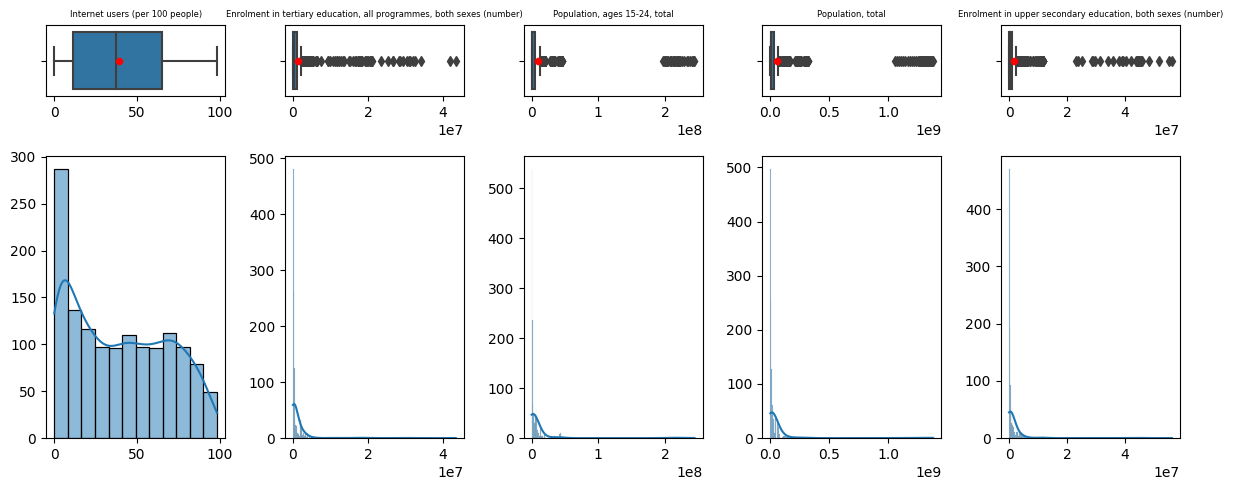

In [104]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (12,5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each indicator
_, axs = plt.subplots(2, num_indic, gridspec_kw={'height_ratios': (.2, .8)})
for i in range(2*num_indic):
  # Boxplots on the first line
  # Doc for markers used: 
  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html#unfilled-markers
  if i//5==0:
    sns.boxplot(data=data_compRateUp[
        data_compRateUp['Indicator Code']==indic_list[i]], 
        x='Indicator Value', orient='h', ax=axs[0, i], showmeans=True, 
        meanprops={'marker':'8', 
                   'markerfacecolor':'red', 
                   'markeredgecolor':'red', 
                   'markersize':'5'})
    # Remove x axis name
    axs[0, i].set(xlabel='')
    # Set the indicator name as title
    axs[0, i].set_title(labels_list[i], fontsize=6)
  # Histograms on the second line
  elif i//5==1:
    sns.histplot(data_compRateUp[
        data_compRateUp['Indicator Code']==indic_list[i-5]], 
        x='Indicator Value', kde=True, ax=axs[1, i-5])
    # Remove x axis name
    axs[1, i-5].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

## 4.2. By indicator & by region

In [105]:
# Check for the possible values
data_compRateUp['Region'].unique()

array(['Latin America & Caribbean', 'Europe & Central Asia',
       'East Asia & Pacific', 'Sub-Saharan Africa', 'South Asia',
       'Middle East & North Africa', nan, 'North America'], dtype=object)

In [106]:
# Define a valid list (without 'nan')
regions = ['East Asia & Pacific', 'Europe & Central Asia', 
           'Latin America & Caribbean', 'Middle East & North Africa', 
           'North America', 'South Asia', 'Sub-Saharan Africa']

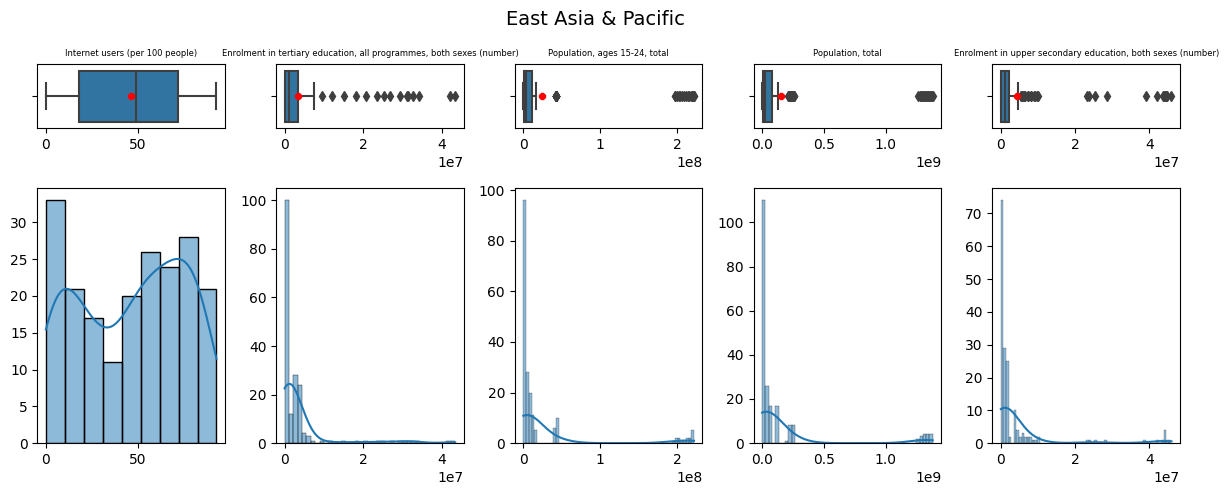

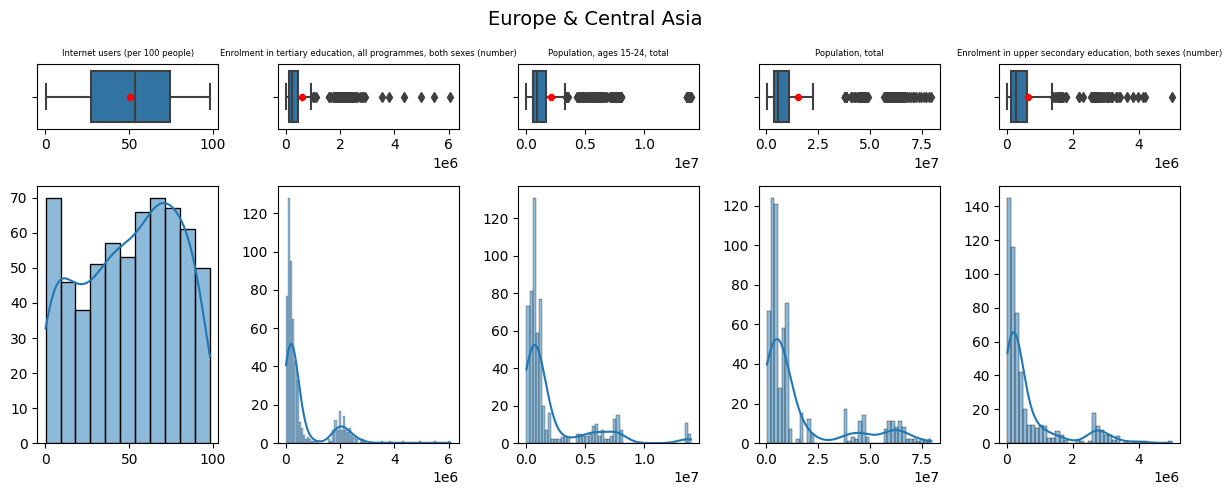

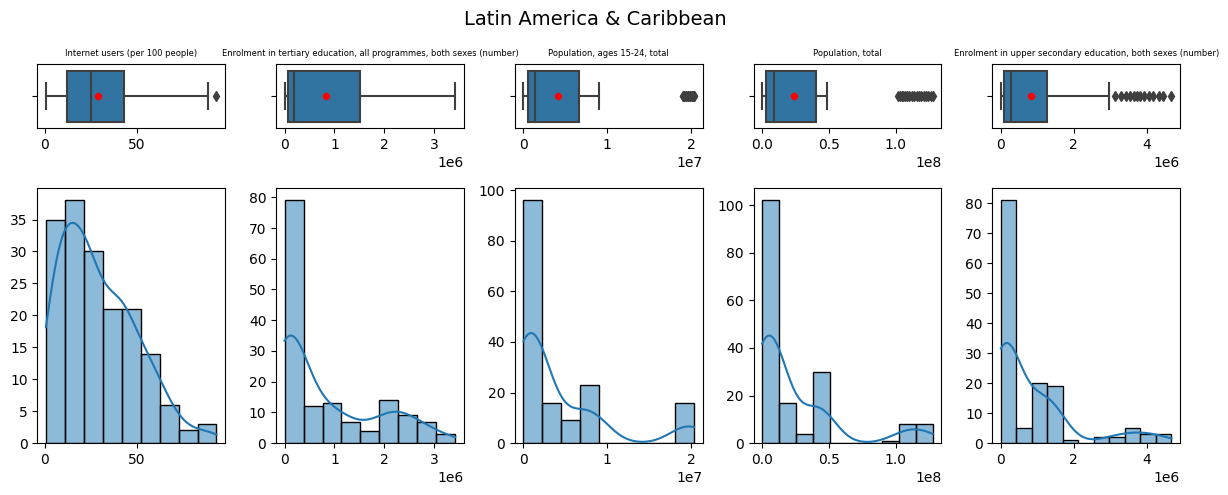

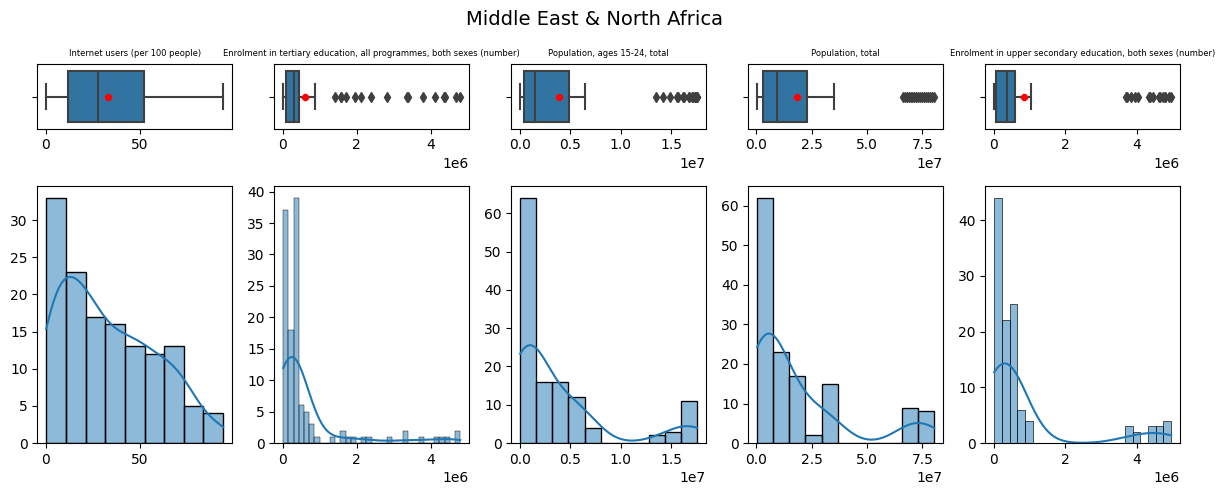

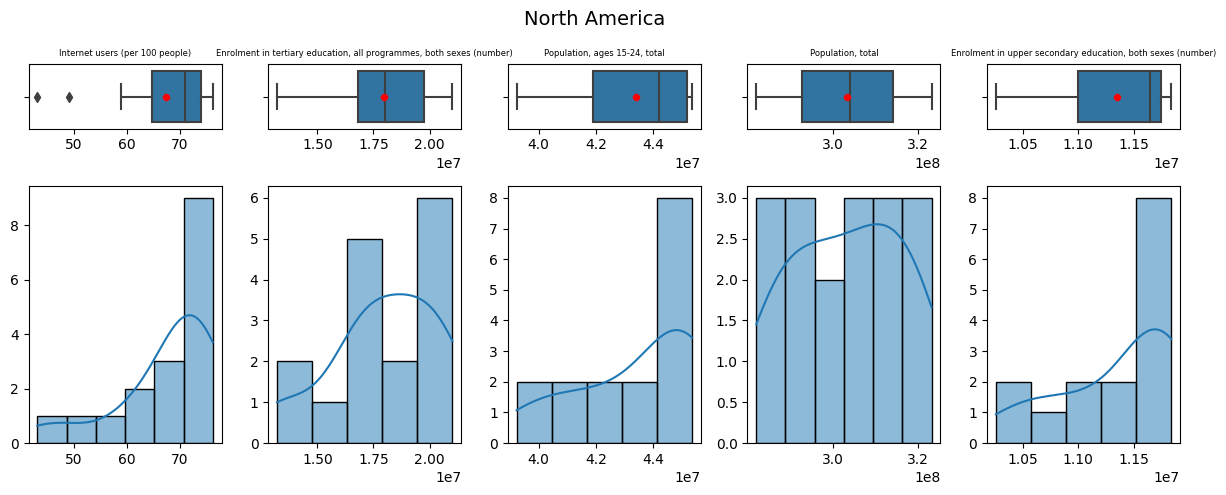

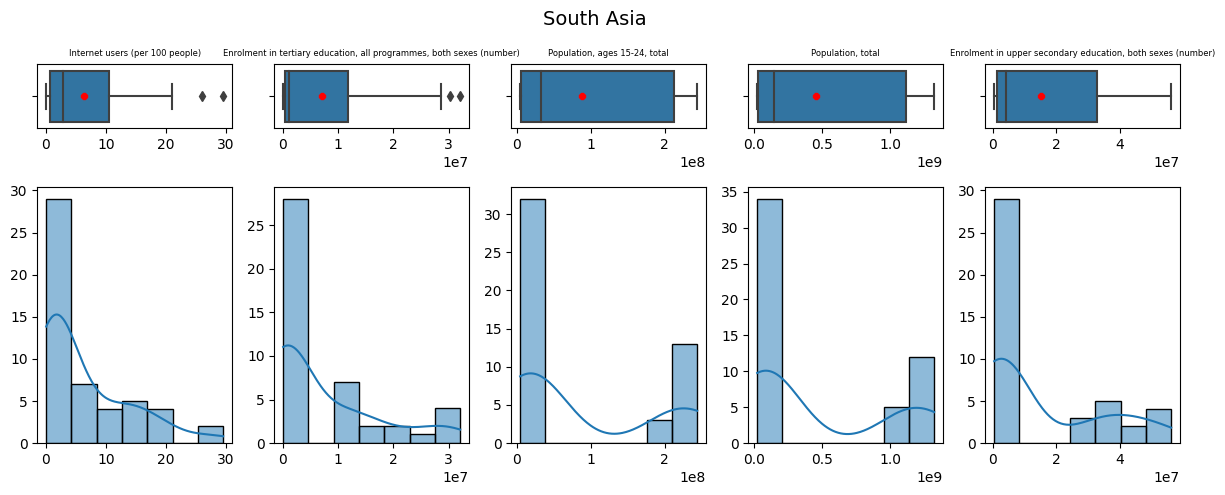

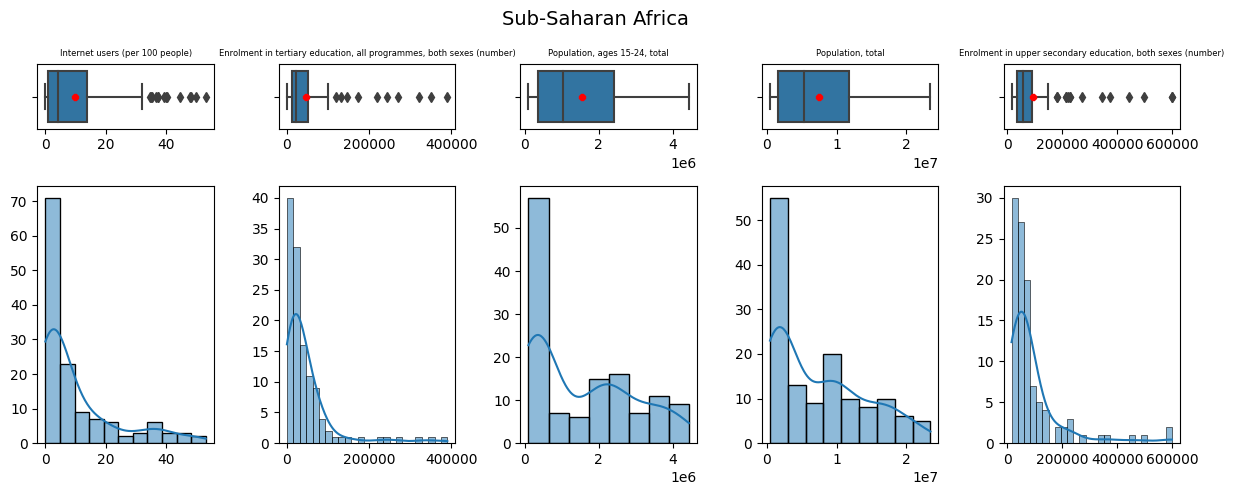

In [107]:
for region in regions:
  # Same plot as before, one by region
  subset_region = data_compRateUp[data_compRateUp['Region']==region]

  # Plot for each indicator
  _, axs = plt.subplots(2, num_indic, gridspec_kw={'height_ratios': (.2, .8)})
  for i in range(2*num_indic):
    # Boxplots on the first line
    if i//5==0:
      sns.boxplot(data=subset_region[
          subset_region['Indicator Code']==indic_list[i]], 
          x='Indicator Value', orient='h', ax=axs[0, i], showmeans=True, 
          meanprops={'marker':'8', 
                    'markerfacecolor':'red', 
                    'markeredgecolor':'red', 
                    'markersize':'5'})
      # Remove x axis name
      axs[0, i].set(xlabel='')
      # Set the indicator name as title
      axs[0, i].set_title(labels_list[i], fontsize=6)
    # Histograms on the second line
    elif i//5==1:
      sns.histplot(subset_region[
          subset_region['Indicator Code']==indic_list[i-5]], 
          x='Indicator Value', kde=True, ax=axs[1, i-5])
      # Remove x axis name
      axs[1, i-5].set(xlabel='', ylabel='')
  # Set the title
  plt.suptitle(region, fontsize=14)
  plt.tight_layout()
  plt.show()

## 4.3. By indicator & by income group

In [108]:
# Check for the possible values
data_compRateUp['Income Group'].unique()

array(['High income: nonOECD', 'Upper middle income',
       'Lower middle income', 'High income: OECD', 'Low income', nan],
      dtype=object)

In [109]:
# Define a valid list (without 'nan')
income_groups = ['Low income', 'Lower middle income', 'Upper middle income', 
                 'High income: nonOECD', 'High income: OECD']

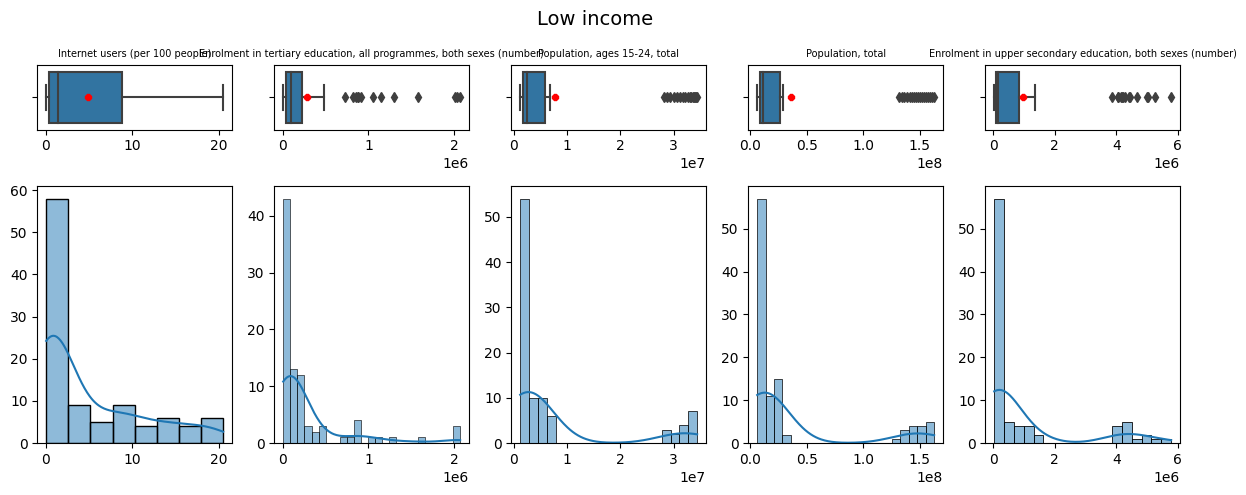

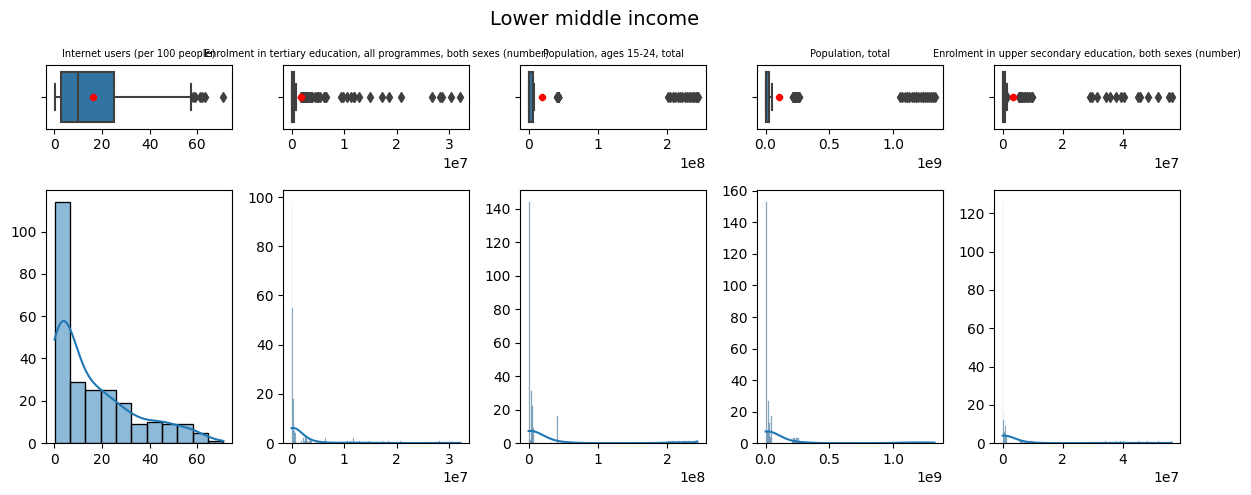

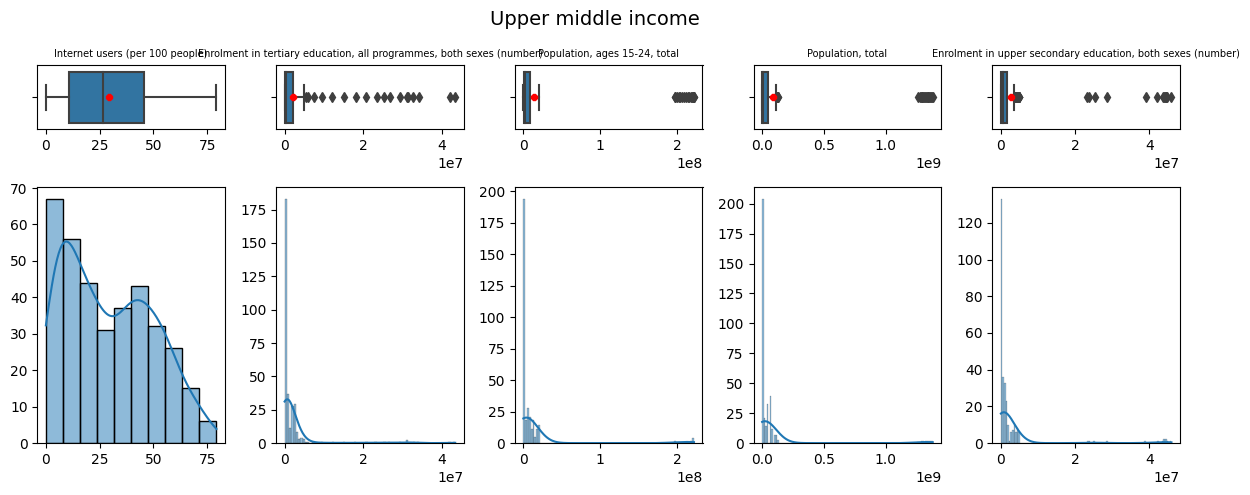

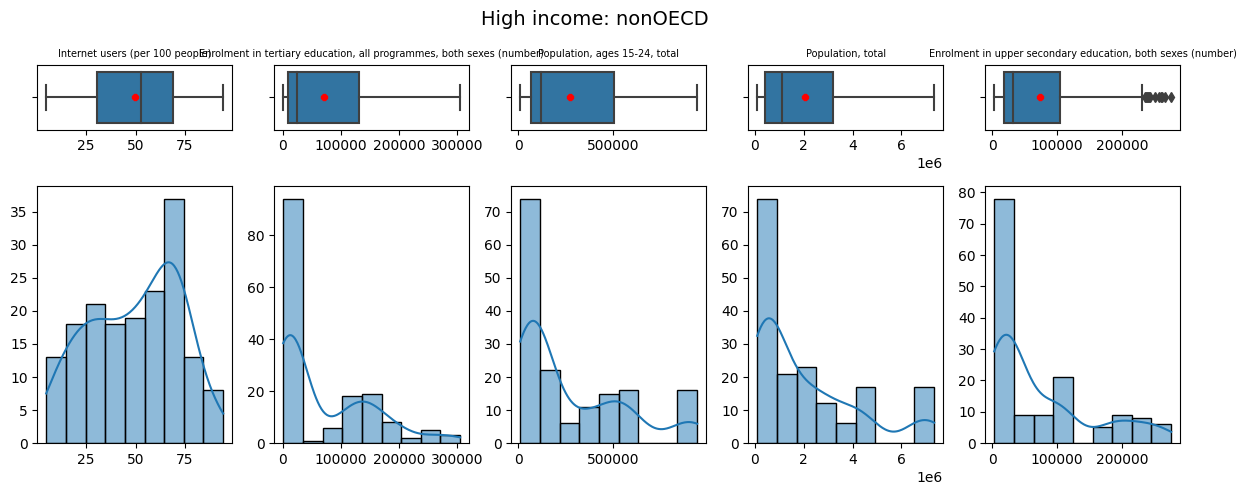

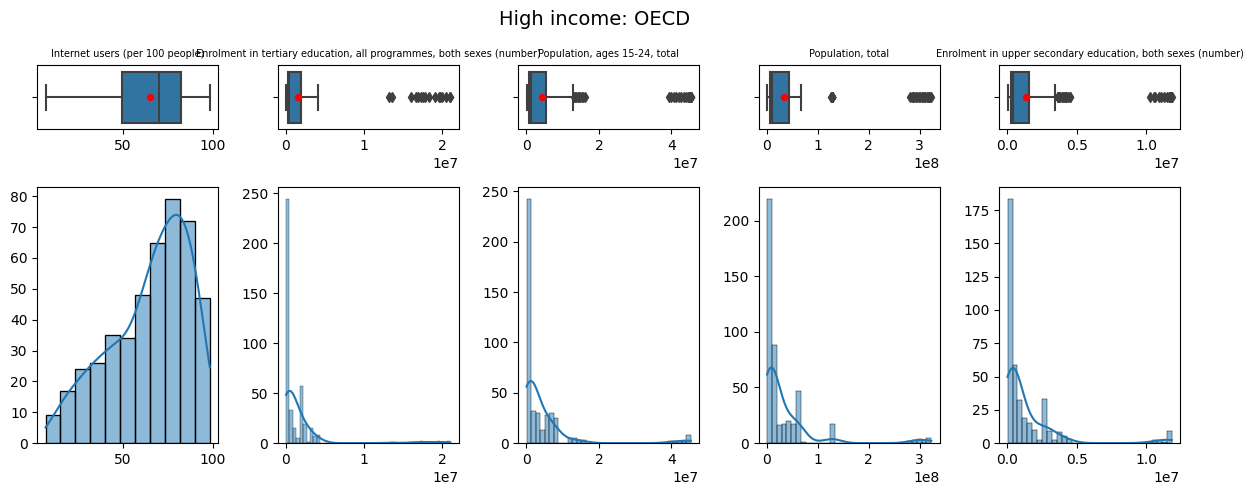

In [110]:
for income_group in income_groups:
  # Same plot as before, one by region
  subset_income = data_compRateUp[data_compRateUp['Income Group']==income_group]

  # Plot for each indicator
  _, axs = plt.subplots(2, num_indic, gridspec_kw={'height_ratios': (.2, .8)})
  for i in range(2*num_indic):
    # Boxplots on the first line
    if i//5==0:
      sns.boxplot(data=subset_income[
          subset_income['Indicator Code']==indic_list[i]], 
          x='Indicator Value', orient='h', ax=axs[0, i], showmeans=True, 
          meanprops={'marker':'8', 
                    'markerfacecolor':'red', 
                    'markeredgecolor':'red', 
                    'markersize':'5'})
      # Remove x axis name
      axs[0, i].set(xlabel='')
      # Set the indicator name as title
      axs[0, i].set_title(labels_list[i], fontsize=7)
    # Histograms on the second line
    elif i//5==1:
      sns.histplot(subset_income[
          subset_income['Indicator Code']==indic_list[i-5]], 
          x='Indicator Value', kde=True, ax=axs[1, i-5])
      # Remove x axis name
      axs[1, i-5].set(xlabel='', ylabel='')
  # Set the title
  plt.suptitle(income_group, fontsize=14)
  plt.tight_layout()
  plt.show()

# 5. Analysis

## 5.1. Data preparation for analysis

In [111]:
print(tabulate(data_compRateUp.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code   | Indicator Name                  | Table Name   | Region                    | Income Group         |   Year |   Indicator Value |
|----|----------------|------------------|---------------------------------|--------------|---------------------------|----------------------|--------|-------------------|
|  0 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |            15.443 |
|  1 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |            17.1   |
|  2 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |            18.8   |
|  3 | ABW            | IT.NET.USER.P2   | Internet users (per 100 people) | Aruba        | Latin America & Caribbean | High income: nonOECD

In [112]:
# First remove the indictator name for now
data_analysis = data_compRateUp.drop(columns='Indicator Name')
print(tabulate(data_analysis.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code   | Table Name   | Region                    | Income Group         |   Year |   Indicator Value |
|----|----------------|------------------|--------------|---------------------------|----------------------|--------|-------------------|
|  0 | ABW            | IT.NET.USER.P2   | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |            15.443 |
|  1 | ABW            | IT.NET.USER.P2   | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |            17.1   |
|  2 | ABW            | IT.NET.USER.P2   | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |            18.8   |
|  3 | ABW            | IT.NET.USER.P2   | Aruba        | Latin America & Caribbean | High income: nonOECD |   2003 |            20.8   |
|  4 | ABW            | IT.NET.USER.P2   | Aruba        | Latin America & Caribbean | High income: nonOECD |   2004 |            23     |


In [113]:
# Let's "pivot" the dataframe on the indicators
# List the indicators
for indic in data_analysis['Indicator Code'].unique():
  print(indic)

IT.NET.USER.P2
SE.TER.ENRL
SP.POP.1524.TO.UN
SP.POP.TOTL
UIS.E.3


### 5.1.1. Make it work on a subset first

In [114]:
# Define the subset (select a few columns)
temp = data_analysis[['Country Code', 'Indicator Code', 'Year', 
                      'Indicator Value']]
print(tabulate(temp.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Indicator Code   |   Year |   Indicator Value |
|----|----------------|------------------|--------|-------------------|
|  0 | ABW            | IT.NET.USER.P2   |   2000 |            15.443 |
|  1 | ABW            | IT.NET.USER.P2   |   2001 |            17.1   |
|  2 | ABW            | IT.NET.USER.P2   |   2002 |            18.8   |
|  3 | ABW            | IT.NET.USER.P2   |   2003 |            20.8   |
|  4 | ABW            | IT.NET.USER.P2   |   2004 |            23     |


In [115]:
# Create a subset for each indicator
itnet = temp[temp['Indicator Code']=='IT.NET.USER.P2']
pop_tot = temp[temp['Indicator Code']=='SP.POP.TOTL']
pop_1524 = temp[temp['Indicator Code']=='SP.POP.1524.TO.UN']
scndary = temp[temp['Indicator Code']=='UIS.E.3']
unvrsty = temp[temp['Indicator Code']=='SE.TER.ENRL']

In [116]:
# Let's rework each subset:
# - delete the 'Indicator Code'
# - rename the 'Indicator Value' column
itnet_rm = itnet.drop(columns=['Indicator Code'])
itnet_rn = itnet_rm.rename(columns={'Indicator Value':'Internet users %'})
print(tabulate(itnet_rn.head(5), headers='keys', tablefmt='github'))

|    | Country Code   |   Year |   Internet users % |
|----|----------------|--------|--------------------|
|  0 | ABW            |   2000 |             15.443 |
|  1 | ABW            |   2001 |             17.1   |
|  2 | ABW            |   2002 |             18.8   |
|  3 | ABW            |   2003 |             20.8   |
|  4 | ABW            |   2004 |             23     |


In [117]:
# Same for another indicator
pop_tot_rm = pop_tot.drop(columns=['Indicator Code'])
pop_tot_rn = pop_tot_rm.rename(
    columns={'Indicator Value':'Pop total'})
print(tabulate(pop_tot_rn.head(5), headers='keys', tablefmt='github'))

|    | Country Code   |   Year |   Pop total |
|----|----------------|--------|-------------|
| 51 | ABW            |   2000 |       90853 |
| 52 | ABW            |   2001 |       92898 |
| 53 | ABW            |   2002 |       94992 |
| 54 | ABW            |   2003 |       97017 |
| 55 | ABW            |   2004 |       98737 |


In [118]:
# Let's merge these together
merged_temp = pd.merge(itnet_rn, 
                       pop_tot_rn[['Country Code', 'Year', 'Pop total']], 
                       how='left', 
                       left_on=['Country Code', 'Year'], 
                       right_on=['Country Code', 'Year'])
print(tabulate(merged_temp.head(5), headers='keys', tablefmt='github'))

|    | Country Code   |   Year |   Internet users % |   Pop total |
|----|----------------|--------|--------------------|-------------|
|  0 | ABW            |   2000 |             15.443 |       90853 |
|  1 | ABW            |   2001 |             17.1   |       92898 |
|  2 | ABW            |   2002 |             18.8   |       94992 |
|  3 | ABW            |   2003 |             20.8   |       97017 |
|  4 | ABW            |   2004 |             23     |       98737 |


### 5.1.2. Now apply these changes to the dataframe

In [119]:
# Create a subset for each indicator
itnet = data_analysis[data_analysis['Indicator Code']=='IT.NET.USER.P2']
pop_tot = data_analysis[data_analysis['Indicator Code']=='SP.POP.TOTL']
pop_1524 = data_analysis[data_analysis['Indicator Code']=='SP.POP.1524.TO.UN']
scndary = data_analysis[data_analysis['Indicator Code']=='UIS.E.3']
unvrsty = data_analysis[data_analysis['Indicator Code']=='SE.TER.ENRL']

In [120]:
# Check for MIN/MAX values to know if possible to rescale
itnet.describe()

,Indicator Value
count,1373.000000
mean,39.379466
std,29.181325
min,0.049000
25%,11.484000
50%,37.176000
75%,65.000000
max,98.240000


In [121]:
# Check for MIN/MAX values to know if possible to rescale
pop_tot.describe()

,Indicator Value
count,1.377000e+03
mean,5.664306e+07
std,1.978544e+08
min,9.085300e+04
25%,3.415213e+06
50%,7.939573e+06
75%,2.977450e+07
max,1.378665e+09


In [122]:
# Check for MIN/MAX values to know if possible to rescale
pop_1524.describe()

,Indicator Value
count,1.296000e+03
mean,9.517879e+06
std,3.423956e+07
min,1.127800e+04
25%,5.637898e+05
50%,1.182872e+06
75%,5.395332e+06
max,2.441202e+08


In [123]:
# Check for MIN/MAX values to know if possible to rescale
scndary.describe()

,Indicator Value
count,1.152000e+03
mean,1.882982e+06
std,6.280290e+06
min,3.119000e+03
25%,1.005962e+05
50%,2.818140e+05
75%,1.082707e+06
max,5.614189e+07


In [124]:
# Check for MIN/MAX values to know if possible to rescale
unvrsty.describe()

,Indicator Value
count,1.259000e+03
mean,1.452424e+06
std,4.259472e+06
min,7.180000e+02
25%,9.377000e+04
50%,2.434250e+05
75%,9.524900e+05
max,4.336739e+07


In [125]:
# Let's rework each subset:
# - delete the 'Indicator Code'
# - rename the 'Indicator Value' column

# Internet user (per 100 people)
itnet = itnet.drop(columns=['Indicator Code'])
itnet = itnet.rename(
    columns={'Indicator Value':'Internet users %'})

# Population, total
pop_tot = pop_tot.drop(columns=['Indicator Code'])
# Let's slightly reduce the range
pop_tot['Indicator Value'] /= 1000
pop_tot = pop_tot.rename(
    columns={'Indicator Value':'Pop total (thousands)'})

# Population, ages 15-24, total
pop_1524 = pop_1524.drop(columns=['Indicator Code'])
# Let's slightly reduce the range
pop_1524['Indicator Value'] /= 1000
pop_1524 = pop_1524.rename(
    columns={'Indicator Value':'Pop 15-24 (thousands)'})

# Enrolment in upper secondary education, both sexes (number)
scndary = scndary.drop(columns=['Indicator Code'])
# Let's slightly reduce the range
scndary['Indicator Value'] /= 1000
scndary = scndary.rename(
    columns={'Indicator Value':'Enrolment secondary (thousands)'})

# Enrolment in tertiary education, all programmes, both sexes (number)
unvrsty = unvrsty.drop(columns=['Indicator Code'])
# Let's slightly reduce the range
unvrsty['Indicator Value'] /= 1000
unvrsty = unvrsty.rename(
    columns={'Indicator Value':'Enrolment tertiary (thousands)'})

In [126]:
# Finally, let's merge these together
df_analysis = pd.merge(itnet, 
                       pop_tot[['Country Code', 'Year', 'Pop total (thousands)']], 
                       how='left', 
                       left_on=['Country Code', 'Year'], 
                       right_on=['Country Code', 'Year'])
print(tabulate(df_analysis.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   Internet users % |   Pop total (thousands) |
|----|----------------|--------------|---------------------------|----------------------|--------|--------------------|-------------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |             15.443 |                  90.853 |
|  1 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |             17.1   |                  92.898 |
|  2 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |             18.8   |                  94.992 |
|  3 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2003 |             20.8   |                  97.017 |
|  4 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2004 |             23     |     

In [127]:
# Now adding the population (ages 15-24)
df_analysis = pd.merge(df_analysis, 
                       pop_1524[['Country Code', 'Year', 'Pop 15-24 (thousands)']], 
                       how='left', 
                       left_on=['Country Code', 'Year'], 
                       right_on=['Country Code', 'Year'])
print(tabulate(df_analysis.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   Internet users % |   Pop total (thousands) |   Pop 15-24 (thousands) |
|----|----------------|--------------|---------------------------|----------------------|--------|--------------------|-------------------------|-------------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |             15.443 |                  90.853 |                  11.278 |
|  1 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |             17.1   |                  92.898 |                  11.534 |
|  2 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |             18.8   |                  94.992 |                  11.465 |
|  3 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2003 |             20.8   |                  97.

In [128]:
# Now adding the enrolment in upper secondary education
df_analysis = pd.merge(df_analysis, 
                       scndary[['Country Code', 'Year', 'Enrolment secondary (thousands)']], 
                       how='left', 
                       left_on=['Country Code', 'Year'], 
                       right_on=['Country Code', 'Year'])
print(tabulate(df_analysis.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   Internet users % |   Pop total (thousands) |   Pop 15-24 (thousands) |   Enrolment secondary (thousands) |
|----|----------------|--------------|---------------------------|----------------------|--------|--------------------|-------------------------|-------------------------|-----------------------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |             15.443 |                  90.853 |                  11.278 |                             3.119 |
|  1 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |             17.1   |                  92.898 |                  11.534 |                             3.318 |
|  2 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |             18.8   |                  94.992 |                  11.46

In [129]:
# Finally adding the enrolment in tertiary education
df_analysis = pd.merge(df_analysis, 
                       unvrsty[['Country Code', 'Year', 'Enrolment tertiary (thousands)']], 
                       how='left', 
                       left_on=['Country Code', 'Year'], 
                       right_on=['Country Code', 'Year']).reset_index(drop=True)
print(tabulate(df_analysis.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   Internet users % |   Pop total (thousands) |   Pop 15-24 (thousands) |   Enrolment secondary (thousands) |   Enrolment tertiary (thousands) |
|----|----------------|--------------|---------------------------|----------------------|--------|--------------------|-------------------------|-------------------------|-----------------------------------|----------------------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |             15.443 |                  90.853 |                  11.278 |                             3.119 |                            1.578 |
|  1 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |             17.1   |                  92.898 |                  11.534 |                             3.318 |                            1.628 |
|  2 | ABW            | Arub

## 5.2. First visual intuition

### 5.2.1. Let's plot the internet users versus the populations

In [131]:
# Let's define the variables
main_var_itnet = 'Internet users %'
targets_itnet = ['Pop total (thousands)', 'Pop 15-24 (thousands)', 
                 'Enrolment secondary (thousands)', 
                 'Enrolment tertiary (thousands)']

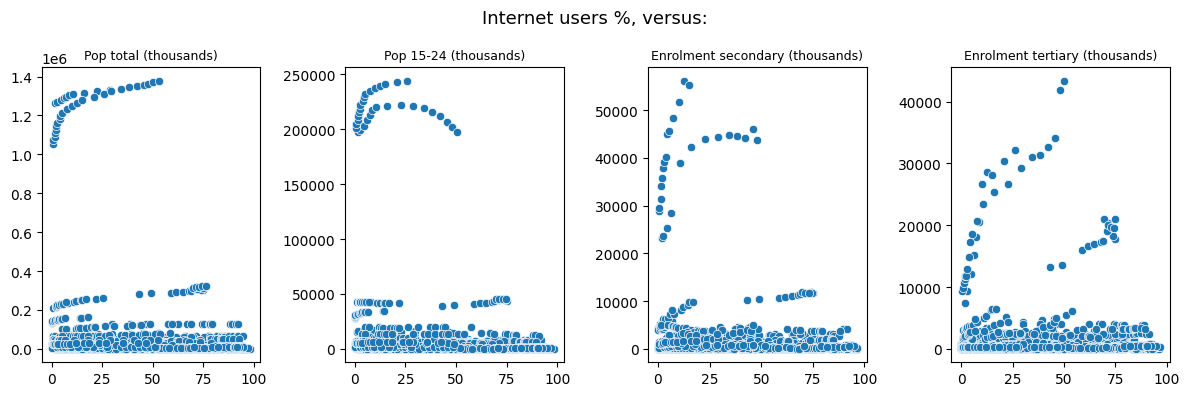

In [132]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (12,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each indicator
_, axs = plt.subplots(1, len(targets_itnet))
for i in range(len(targets_itnet)):
  sns.scatterplot(data=df_analysis, x=main_var_itnet, y=targets_itnet[i], 
                  ax=axs[i])
  # Remove x and y axis' names
  axs[i].set(xlabel='', ylabel='')
  # Set the (sub)plot name
  axs[i].set_title(targets_itnet[i], fontsize=9)
plt.suptitle(f'{main_var_itnet}, versus:', fontsize=13)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

### 5.2.2. Let's plot the "young" population versus the enrolments

In [133]:
# Let's define the variables
main_var_1524 = 'Pop 15-24 (thousands)'
targets_1524 = ['Enrolment secondary (thousands)', 
                'Enrolment tertiary (thousands)']

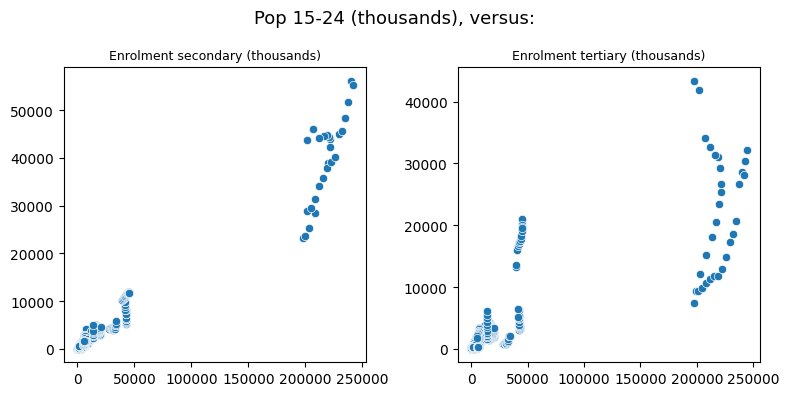

In [134]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each indicator
_, axs = plt.subplots(1, len(targets_1524))
for i in range(len(targets_1524)):
  sns.scatterplot(data=df_analysis, x=main_var_1524, y=targets_1524[i], 
                  ax=axs[i])
  # Remove x and y axis' names
  axs[i].set(xlabel='', ylabel='')
  # Set the (sub)plot name
  axs[i].set_title(targets_1524[i], fontsize=9)
plt.suptitle(f'{main_var_1524}, versus:', fontsize=13)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

## 5.3. Countries to target and evolution

In [135]:
# Start by copying the dataframe
df_potential = df_analysis.copy()

In [136]:
# Create three features based on the % of internet users

# Number of internet users total
df_potential['nbr_itnet_users'] = (df_potential[
    'Internet users %']/100) * df_potential['Pop total (thousands)']

# Number of internet users aged 15-24
df_potential['nbr_itnet_users_1524'] = (df_potential[
    'Internet users %']/100) * df_potential['Pop 15-24 (thousands)']

# Number of internet users in secondary and tertiary
df_potential['nbr_itnet_users_enrol'] = (df_potential[
    'Internet users %']/100) * (df_potential[
        'Enrolment secondary (thousands)'] + df_potential[
            'Enrolment tertiary (thousands)'])

print(tabulate(df_potential.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   Internet users % |   Pop total (thousands) |   Pop 15-24 (thousands) |   Enrolment secondary (thousands) |   Enrolment tertiary (thousands) |   nbr_itnet_users |   nbr_itnet_users_1524 |   nbr_itnet_users_enrol |
|----|----------------|--------------|---------------------------|----------------------|--------|--------------------|-------------------------|-------------------------|-----------------------------------|----------------------------------|-------------------|------------------------|-------------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |             15.443 |                  90.853 |                  11.278 |                             3.119 |                            1.578 |           14.0304 |                1.74166 |                0.725358 |
|  1 | ABW            | Aruba        | Latin America & Car

In [137]:
# I remove some unused columns for this part
dropped_columns = ['Internet users %', 'Pop total (thousands)', 
                   'Pop 15-24 (thousands)', 'Enrolment secondary (thousands)', 
                   'Enrolment tertiary (thousands)']

df_potential = df_potential.drop(columns=dropped_columns)
print(tabulate(df_potential.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   nbr_itnet_users |   nbr_itnet_users_1524 |   nbr_itnet_users_enrol |
|----|----------------|--------------|---------------------------|----------------------|--------|-------------------|------------------------|-------------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |           14.0304 |                1.74166 |                0.725358 |
|  1 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |           15.8856 |                1.97231 |                0.845766 |
|  2 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2002 |           17.8585 |                2.15542 |                0.961996 |
|  3 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2003 |           20.1795 |                2.45898 |       

In [138]:
# Create three features relative to each other

# Percentage of internet users aged 15-24
df_potential['itnet_1524_%'] = df_potential[
    'nbr_itnet_users_1524']*100/df_potential['nbr_itnet_users']

# Percentage of internet users enrolled (secondary/tertiary)
df_potential['itnet_enrol_%'] = df_potential[
    'nbr_itnet_users_enrol']*100/df_potential['nbr_itnet_users']

# Percentage of internet users enrolled vs 15-24
df_potential['itnet_enrol_1524_%'] = df_potential[
    'nbr_itnet_users_enrol']*100/df_potential['nbr_itnet_users_1524']

print(tabulate(df_potential.head(5), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name   | Region                    | Income Group         |   Year |   nbr_itnet_users |   nbr_itnet_users_1524 |   nbr_itnet_users_enrol |   itnet_1524_% |   itnet_enrol_% |   itnet_enrol_1524_% |
|----|----------------|--------------|---------------------------|----------------------|--------|-------------------|------------------------|-------------------------|----------------|-----------------|----------------------|
|  0 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2000 |           14.0304 |                1.74166 |                0.725358 |        12.4135 |         5.16989 |              41.6475 |
|  1 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD |   2001 |           15.8856 |                1.97231 |                0.845766 |        12.4158 |         5.32412 |              42.8819 |
|  2 | ABW            | Aruba        | Latin America & Caribbean | High income: nonOECD 

### 5.3.1. Countries to target

This can also be done by Region or Income Group, for instance.

In [139]:
# I will now focus on the data of the last year (2016)
df_2016 = df_potential[df_potential['Year']=='2016'].reset_index(drop=True)

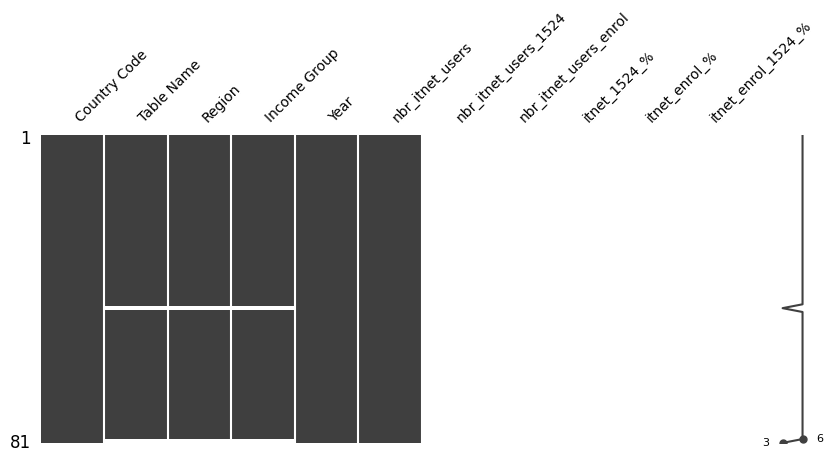

In [140]:
_ = msno.matrix(df=df_2016, figsize=(10,4), fontsize=10)

Since I do not intend to "fill in the blanks", I cannot properly exploit the data of this year, since I have no values for my last two columns.
I decide to use the data of 2014 since there are more values.

In [141]:
# Select the data of 2014
df_2014 = df_potential[df_potential['Year']=='2014'].reset_index(drop=True)

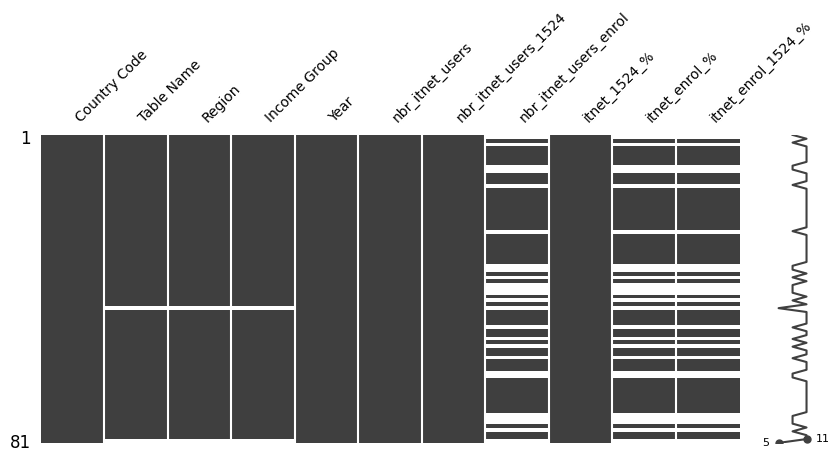

In [142]:
_ = msno.matrix(df=df_2014, figsize=(10,4), fontsize=10)

There are less missing values here, I can work with this.

In [145]:
df_2014_sorted_1524 = df_2014.sort_values(by=['itnet_1524_%'], 
                                          ascending=False)
print(tabulate(df_2014_sorted_1524.head(8), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name           | Region                     | Income Group        |   Year |   nbr_itnet_users |   nbr_itnet_users_1524 |   nbr_itnet_users_enrol |   itnet_1524_% |   itnet_enrol_% |   itnet_enrol_1524_% |
|----|----------------|----------------------|----------------------------|---------------------|--------|-------------------|------------------------|-------------------------|----------------|-----------------|----------------------|
| 60 | NPL            | Nepal                | South Asia                 | Low income          |   2014 |          4373.11  |              1038.42   |               277.027   |        23.7455 |         6.33478 |             26.6778  |
| 65 | PSE            | West Bank and Gaza   | Middle East & North Africa | Lower middle income |   2014 |          2304.96  |               545.803  |               191.064   |        23.6795 |         8.28927 |             35.0061  |
| 19 | CPV            | Cabo Verde           | Sub-Sahar

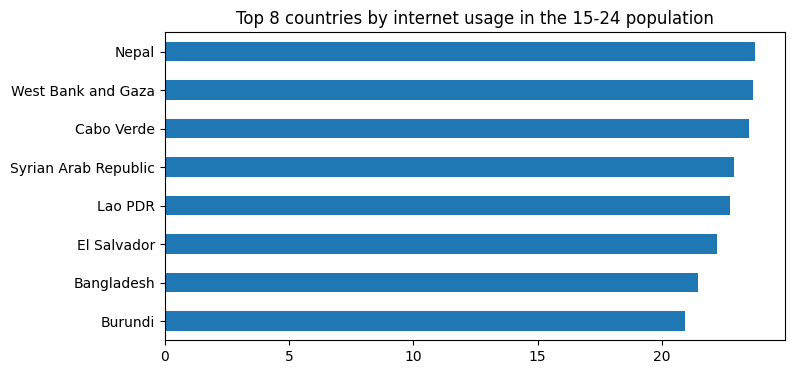

In [147]:
# Let's start by plotting the countries with the highest 
# internet 1524 percentage

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Barplot
df_2014_sorted_1524.head(8).plot.barh(x='Table Name', y='itnet_1524_%', 
                                       legend=False).invert_yaxis()
plt.title('Top 8 countries by internet usage in the 15-24 population')
# Remove the y-axis label
plt.ylabel('')
plt.show()

In [148]:
df_2014_sorted_enrol = df_2014.sort_values(by=['itnet_enrol_%'], 
                                           ascending=False)
print(tabulate(df_2014_sorted_enrol.head(8), headers='keys', tablefmt='github'))

|    | Country Code   | Table Name        | Region                    | Income Group         |   Year |   nbr_itnet_users |   nbr_itnet_users_1524 |   nbr_itnet_users_enrol |   itnet_1524_% |   itnet_enrol_% |   itnet_enrol_1524_% |
|----|----------------|-------------------|---------------------------|----------------------|--------|-------------------|------------------------|-------------------------|----------------|-----------------|----------------------|
| 15 | CHL            | Chile             | Latin America & Caribbean | High income: OECD    |   2014 |         10763.8   |              1748.37   |               1367.17   |        16.2431 |         12.7015 |              78.1964 |
| 26 | FIN            | Finland           | Europe & Central Asia     | High income: OECD    |   2014 |          4725.85  |               558.359  |                574.239  |        11.815  |         12.151  |             102.844  |
|  7 | BEL            | Belgium           | Europe & Central Asia   

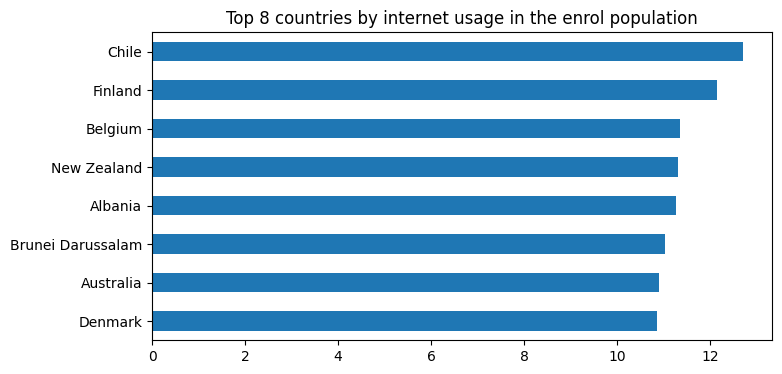

In [149]:
# Then let's plot the countries with the highest
# internet enrolled percentage

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Barplot
df_2014_sorted_enrol.head(8).plot.barh(x='Table Name', y='itnet_enrol_%', 
                                        legend=False).invert_yaxis()
plt.title('Top 8 countries by internet usage in the enrol population')
# Remove the y-axis label
plt.ylabel('')
plt.show()

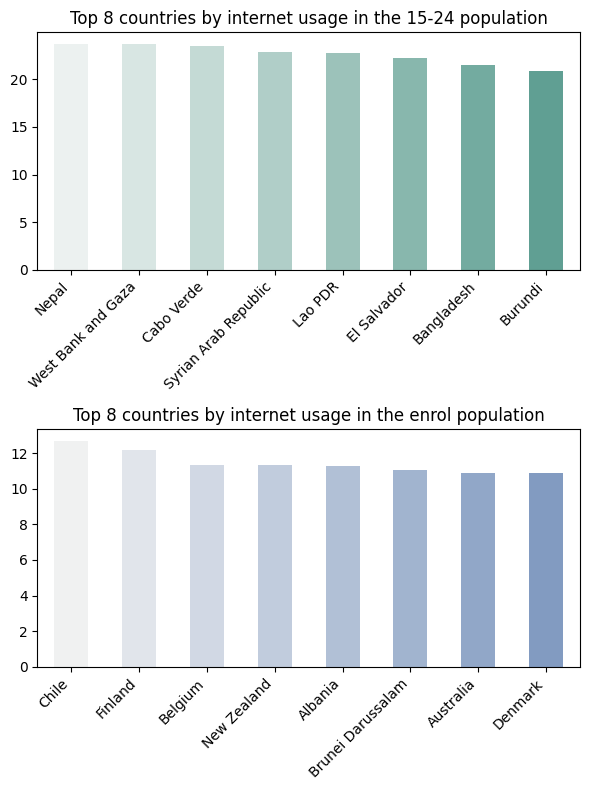

In [165]:
# Let's combine these results in a same plot

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (6,8)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for both populations
_, axs = plt.subplots(2, 1)
ax0 = sns.barplot(data=df_2014_sorted_1524.head(8), 
                  x='Table Name', y='itnet_1524_%', ax=axs[0], 
                  palette=sns.light_palette('#5A9', 8), width=.5)
ax0.set_xticklabels(ax0.get_xticklabels(), 
                    rotation=45, horizontalalignment='right')
ax1 = sns.barplot(data=df_2014_sorted_enrol.head(8), 
                  x='Table Name', y='itnet_enrol_%', 
                  ax=axs[1], palette=sns.light_palette('#79C', 8), width=.5)
ax1.set_xticklabels(ax1.get_xticklabels(), 
                    rotation=45, horizontalalignment='right')
# Remove x and y axis name, set the subplots titles
ax0.set(xlabel='', ylabel='', 
        title='Top 8 countries by internet usage in the 15-24 population')
ax1.set(xlabel='', ylabel='', 
        title='Top 8 countries by internet usage in the enrol population')
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

# List of colors for subplots:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html

We get some very different targets here, so let's focus on the top countries from the first plot.

### 5.3.2. Evolution

In [168]:
# Let's filter on the retained countries
target_countries = ['Nepal', 'West Bank and Gaza', 'Cabo Verde', 
                    'Syrian Arab Republic', 'Lao PDR', 'El Salvador', 
                    'Bangladesh', 'Burundi']

In [171]:
df_targets = df_potential[df_potential['Table Name'].isin(target_countries)]
print(tabulate(df_targets.head(5), headers='keys', tablefmt='github'))

|     | Country Code   | Table Name   | Region             | Income Group   |   Year |   nbr_itnet_users |   nbr_itnet_users_1524 |   nbr_itnet_users_enrol |   itnet_1524_% |   itnet_enrol_% |   itnet_enrol_1524_% |
|-----|----------------|--------------|--------------------|----------------|--------|-------------------|------------------------|-------------------------|----------------|-----------------|----------------------|
| 102 | BDI            | Burundi      | Sub-Saharan Africa | Low income     |   2000 |           4.92854 |                1.01259 |               0.028269  |        20.5455 |        0.573577 |              2.79174 |
| 103 | BDI            | Burundi      | Sub-Saharan Africa | Low income     |   2001 |           6.94918 |                1.46718 |               0.038902  |        21.113  |        0.559807 |              2.65148 |
| 104 | BDI            | Burundi      | Sub-Saharan Africa | Low income     |   2002 |           7.95505 |                1.72823 |     

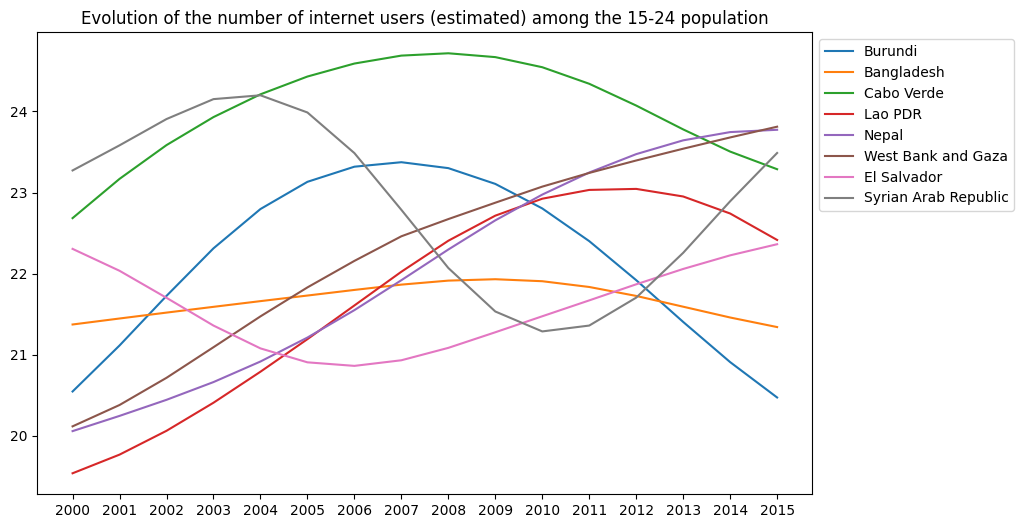

In [187]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (10,6)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

sns.lineplot(data=df_targets, x='Year', y='itnet_1524_%', hue='Table Name')
# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1, 1))
# Set the title
plt.title('Evolution of the number of internet users (estimated) among the 15-24 population')
# Remove the x-axis label
plt.xlabel('')
# Remove the y-axis label
plt.ylabel('')
plt.show()